# Training pipeline


### 0. import

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
from tqdm import tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import random
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.models as models

### 1. Configuration

##### path & format


In [2]:
# 1. 基本參數設定
NUM_CLASSES_DETAILED = 12 # Detailed (12類): 0:BG, 1:SA, 2:RF, 3:VL, 4:VI, 5:VM, 6:AM, 7:GR, 8:BFL, 9:ST, 10:SM, 11:BFS
NUM_CLASSES_ROUGH = 5 # Rough (5類): 0:BG, 1:SA, 2:QF, 3:GR, 4:HS
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 8
PIN_MEMORY = True

# 2. 資料路徑
PROJECT_ROOT = "/home/n26141826/114-1_TAICA_cv_Final_Project"
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "npy_Embedding")
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train") 
TEST_DATA_DIR = os.path.join(DATA_DIR, "test")

CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "checkpoints" , "checkpoints_3step_3img_256_DiceCELoss_200ep")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results" , "results_3step_3img_256_DiceCELoss_200ep")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
DEBUG_DATA_DIR = os.path.join(CHECKPOINT_DIR, 'loader_debug')
os.makedirs(DEBUG_DATA_DIR, exist_ok=True)


# 3. 模型存檔路徑 (Model Checkpoints)
ROUGH_MODEL_PATH  = os.path.join(CHECKPOINT_DIR, "rough_model_best.pth")
WARMUP_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "warmup_model.pth")
DETAIL_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "detail_model_best.pth")
DETAIL_MODEL2_PATH = os.path.join(CHECKPOINT_DIR, "detail_model_best_loss.pth")
EVAL_MODEL_PATH   = DETAIL_MODEL_PATH

# 4. train loss / val loss 紀錄路徑
ROUGH_LOSS_LOG  = os.path.join(RESULTS_DIR, "rough_loss.csv")
ROUGH_LOSS_IMG   = os.path.join(RESULTS_DIR, "rough_loss.png")
WARMUP_LOSS_LOG = os.path.join(RESULTS_DIR, "warmup_loss.csv")
WARMUP_LOSS_IMG  = os.path.join(RESULTS_DIR, "warmup_loss.png")
DETAIL_LOSS_LOG = os.path.join(RESULTS_DIR, "detail_loss.csv")
DETAIL_LOSS_IMG  = os.path.join(RESULTS_DIR, "detail_loss.png")


# 5. 評估輸出路徑
EVAL_CSV_OUTPUT = os.path.join(RESULTS_DIR, "evaluation_metrics_per_sequence.csv")
FLATTENED_METRICS_OUTPUT = os.path.join(RESULTS_DIR, "flattened_metrics.csv")

# 模型架構參數 (Model Architecture)
IN_CHANNELS = 3        # 輸入影像通道數 - 2.5D (3 張 MRI 序列)
EMBEDDING_DIM = 64     # 條件向量 (Type/Pos) 的維度
NUM_MRI_TYPES = 5      # MRI 序列總數 (Water, Fat, T1, T2, STIR)

# 視覺化設定
VIZ_INTERVAL = 50

print(f"✅ Configuration Loaded!")
print(f"   - Device       : {DEVICE}")
print(f"   - Data         : {DATA_DIR}")
print(f"   - Checkpoints  : {CHECKPOINT_DIR}")
print(f"   - Results      : {RESULTS_DIR}")
print(f"   - loader images: {DEBUG_DATA_DIR}")

✅ Configuration Loaded!
   - Device       : cuda:1
   - Data         : /home/n26141826/114-1_TAICA_cv_Final_Project/data/npy_Embedding
   - Checkpoints  : /home/n26141826/114-1_TAICA_cv_Final_Project/checkpoints/checkpoints_3step_3img_256_DiceCELoss_200ep
   - Results      : /home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_3img_256_DiceCELoss_200ep
   - loader images: /home/n26141826/114-1_TAICA_cv_Final_Project/checkpoints/checkpoints_3step_3img_256_DiceCELoss_200ep/loader_debug


#### Training Hyper-parameter

In [3]:
TARGET_SIZE = 256
# 幾何變換 (Joint Transform: Image + Label)
AUG_P_FLIP = 0.5          # 左右翻轉的機率
AUG_P_SCALE = 0.5         # 隨機縮放的機率
AUG_LIMIT_SCALE = 0.1     # 縮放幅度 (0.1 代表 0.9x ~ 1.1x)
AUG_P_ROTATE = 0.3            # 旋轉機率
AUG_LIMIT_ROTATE = 15         # 旋轉角度範圍 (-15 ~ +15)
AUG_P_ELASTIC = 0.3           # 彈性變形機率 (模擬肌肉擠壓)
AUG_ELASTIC_ALPHA = 120       # 變形強度
AUG_ELASTIC_SIGMA = 120 * 0.05
AUG_P_GRID = 0.3              # 網格扭曲機率 (模擬腿型差異)

# 像素變換 (Independent Transform: Image Only)
AUG_P_BRIGHTNESS = 0.5    # 亮度/對比度調整機率
AUG_LIMIT_BRIGHT = 0.2    # 亮度調整幅度 (+-20%)
AUG_LIMIT_CONTRAST = 0.2  # 對比度調整幅度 (+-20%)
AUG_P_GAUSS_BLUR = 0.2        # 高斯模糊機率 (保留模糊以模擬動態模糊)
AUG_P_CLAHE = 0.5             # CLAHE (救 STIR 神器) 機率
AUG_CLAHE_CLIP = 4.0          # CLAHE 對比度限制

# Pre-train (Rough)
ROUGH_BATCH_SIZE = 16
ROUGH_LR = 1e-3
ROUGH_EPOCHS = 150

# Hierarchical Warm-up (Detail Head Warm-up)
WARMUP_BATCH_SIZE = 16    # 使用 Detail Data，通常量較少或需較小 Batch
WARMUP_LR = 1e-3          # 只訓練 Head，可以用大一點的 LR
WARMUP_EPOCHS = 30        # 短暫熱身即可
# 控制 Student(Detail) 模仿 Teacher(Rough) 的強度
# 建議範圍: 0.1 ~ 1.0
CONSISTENCY_WEIGHT = 0.5

# Fine-tune (Detail)
DETAIL_BATCH_SIZE = 16
DETAIL_EPOCHS = 200
DETAIL_LR_ENCODER = 1e-5 # Encoder 慢慢修 (微整形)
DETAIL_LR_DECODER = 1e-4 # Decoder 正常學

# Mappings & Definitions
ROUGH_MAP = [0, 1, 2, 2, 2, 2, 0, 3, 4, 4, 4, 4]  # 0:BG, 1:SA, 2:QF, 3:GR, 4:HS
# MRI 序列映射表 (Modality Mapping)
TYPE_MAP = {
    'Water': 0,
    'FATFRACTION': 1, # 通常將 Fat Fraction 視為 Fat 類別，或依你需求改為獨立 ID
    'Fat': 1,
    'T1': 2,
    'T2': 3,
    'STIR': 4
}
ID_TO_TYPE = {v: k for k, v in TYPE_MAP.items()}

# 定義映射矩陣 (12類 -> 5類)
# 0:BG, 1:SA, 2:RF, 3:VL, 4:VI, 5:VM, 6:AM, 7:GR, 8:BFL, 9:ST, 10:SM, 11:BFS
# Map to: 0:BG, 1:SA, 2:QF, 3:GR, 4:HS
MAPPING_MATRIX = torch.tensor([
    [1, 0, 0, 0, 0], # 0->0
    [0, 1, 0, 0, 0], # 1->1
    [0, 0, 1, 0, 0], # 2->2
    [0, 0, 1, 0, 0], # 3->2
    [0, 0, 1, 0, 0], # 4->2
    [0, 0, 1, 0, 0], # 5->2
    [1, 0, 0, 0, 0], # 6->0 (AM -> BG)
    [0, 0, 0, 1, 0], # 7->3
    [0, 0, 0, 0, 1], # 8->4
    [0, 0, 0, 0, 1], # 9->4
    [0, 0, 0, 0, 1], # 10->4
    [0, 0, 0, 0, 1]  # 11->4
], dtype=torch.float32).to(DEVICE)

# Evaluation Configuration
EVAL_BATCH_SIZE = 1
# 2. 肌肉名稱對照表 (1-11)
MUSCLE_NAMES = {
    1: 'Sartorius',
    2: 'Rectus Femoris',
    3: 'Vastus Lateralis',
    4: 'Vastus Intermedius',
    5: 'Vastus Medialis',
    6: 'Adductor Magnus',
    7: 'Gracilis',
    8: 'Biceps Femoris LH',
    9: 'Semitendinosus',
    10: 'Semimembranosus',
    11: 'Biceps Femoris SH'
}
# 3. 視覺化顏色設定 (Visualization Colors)
VIZ_COLORS = [
    '#000000', '#e6194b', '#006400', '#228B22', '#32CD32', '#7CFC00', 
    '#911eb4', '#46f0f0', '#00008B', '#0000CD', '#4169E1', '#87CEEB'
]
colors_list = list(VIZ_COLORS)
colors_list[0] = (0, 0, 0, 0)
VIZ_CMAP = mcolors.ListedColormap(colors_list)
# VIZ_CMAP = mcolors.ListedColormap(VIZ_COLORS)
VIZ_NORM = mcolors.BoundaryNorm(boundaries=np.arange(13)-0.5, ncolors=12)

### 2. Utilities

In [4]:
# --- Metrics (為了跟組員比對，使用標準 Dice) ---
def dice_score(preds, targets, num_classes):
    # 簡單的 Dice 計算範例，組員可能有更複雜的版本，可替換
    dice_list = []
    preds = torch.argmax(preds, dim=1)
    
    for cls in range(1, num_classes): # Skip background
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        
        score = (2. * intersection + 1e-6) / (union + 1e-6)
        dice_list.append(score.item())
        
    return np.mean(dice_list)

def plot_training_curves(log_path, image_path=None):
    """
    讀取 CSV Log 並畫出 Loss 和 Dice 曲線，
    使用 clear_output 達成即時刷新效果。
    """
    if not os.path.exists(log_path):
        return

    # 讀取數據
    try:
        df = pd.read_csv(log_path)
    except pd.errors.EmptyDataError:
        return

    # 設定畫布 (左邊 Loss, 右邊 Dice)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # --- 1. Loss Curve ---
    ax1.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o', color='tab:blue')
    ax1.plot(df['epoch'], df['val_loss'], label='Val Loss', marker='o', color='tab:orange')
    ax1.set_title("Loss Curve")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()

    # --- 2. Dice Curve ---
    if 'val_dice' in df.columns:
        ax2.plot(df['epoch'], df['val_dice'], label='Val Dice', marker='o', color='tab:green')
        ax2.set_title("Validation Dice Score")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Dice")
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.legend()
        
        # 標出目前的最高分
        max_dice = df['val_dice'].max()
        max_epoch = df.loc[df['val_dice'].idxmax(), 'epoch']
        ax2.annotate(f'Max: {max_dice:.4f}', xy=(max_epoch, max_dice), 
                     xytext=(max_epoch, max_dice - 0.05),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    if image_path:
        plt.savefig(image_path)
    
    # 清除上一次的圖並顯示新的
    clear_output(wait=True)
    plt.show()

### 2. Train - validation split

In [5]:
# 1. 搜尋所有 .npy 檔案
all_files = glob.glob(os.path.join(TRAIN_DATA_DIR, "*.npy"))
print(f"Total .npy files found in train data: {len(all_files)}")

# 2. 依照 Subject 分類
train_files = []
val_files = []
train_detail = []
train_without_detail = []
for i in all_files:
    data = np.load(i, allow_pickle=True).item()
    if data.get('has_detail'):
        train_detail.append(i)
    else:
        train_without_detail.append(i)
# --- split rough only training data & val ---
train_roughonly_subs, val_roughonly_subs = train_test_split(
    train_without_detail, test_size=0.1, random_state=42
)
# --- split detail training data & val ---
train_detail_subs, val_detail_subs = train_test_split(
    train_detail, test_size=0.1, random_state=42
)
# --- combine ---
train_files = train_roughonly_subs + train_detail_subs
val_files = val_roughonly_subs + val_detail_subs
# --- 計算 Train 分佈 ---
train_rough_seq_distribution = {}
for i in train_files:
    data = np.load(i, allow_pickle=True).item()
    key = data.get('type_idx')
    if key not in train_rough_seq_distribution:
        train_rough_seq_distribution[key] = 0
    train_rough_seq_distribution[key] += 1
# --- 計算 Val 分佈 ---
val_rough_seq_distribution = {}
for i in val_files:
    data = np.load(i, allow_pickle=True).item()
    key = data.get('type_idx')
    if key not in val_rough_seq_distribution:
        val_rough_seq_distribution[key] = 0
    val_rough_seq_distribution[key] += 1
# --- log ---
print("-"*30)
print(f"Train Files : {len(train_files)}")
print(f"Val Files   : {len(val_files)}")
print("-"*30)

# --- measure type distribution ---
# 1. 找出所有出現過的類別 ID (取聯集並排序)
all_keys = sorted(set(train_rough_seq_distribution.keys()) | set(val_rough_seq_distribution.keys()))

# 2. 準備資料字典
data = {}
for k in all_keys:
    # 取得類別名稱
    seq_name = ID_TO_TYPE.get(k, f"Unknown({k})")
    
    # 取得 Train 和 Val 的數量
    train_count = train_rough_seq_distribution.get(k, 0)
    val_count = val_rough_seq_distribution.get(k, 0)
    
    # 計算比率 (Val / Train)
    ratio = val_count / train_count if train_count > 0 else 0.0
    
    # 存入字典
    data[seq_name] = [train_count, val_count, ratio]

# 3. 轉成 DataFrame
df_dist = pd.DataFrame.from_dict(data, orient='index', columns=['Train', 'Val', 'Val : Train'])

# 4. 加入 Total 總和列
total_train = df_dist['Train'].sum()
total_val = df_dist['Val'].sum()
total_ratio = total_val / total_train if total_train > 0 else 0.0

df_dist.loc['Total'] = [total_train, total_val, total_ratio]

# 5. 格式化顯示 (顯示百分比可能會更直觀)
styled_df = df_dist.style.format({
    'Train': '{:,.0f}',       # 整數
    'Val': '{:,.0f}',         # 整數
    'Val : Train': '{:.1%}'   # 轉成百分比 (例如 0.11 -> 11.0%)
})
display(styled_df)

Total .npy files found in train data: 11691
------------------------------
Train Files : 10521
Val Files   : 1170
------------------------------


,Train,Val,Val : Train
Water,"2,400",252,10.5%
Fat,"5,350",606,11.3%
T1,"1,512",174,11.5%
T2,694,74,10.7%
STIR,565,64,11.3%
Total,"10,521","1,170",11.1%


### 3. Dataset

In [6]:
class SliceMasterDataset_Strategic25D(Dataset):
    def __init__(self, file_list, mode='rough', data_type='Train', transform=None,):
        self.file_list = file_list
        self.data_type = data_type
        self.mode = mode
        self.transform = transform
        
        # --- 建立快速查找表 (Lookup Table) ---
        # 結構: lookup[subject_id][slice_idx][type_idx] = [file_path1, file_path2, ...]
        self.lookup = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))        
        # 為了加速，只讀取 header 建立索引
        # print(f"Indexing {len(file_list)} files...")
        for f in tqdm(file_list, desc="Building Index"):
            try:
                data = np.load(f, allow_pickle=True).item()
                pid = data['MRI_sample']
                z = data['this_slice'] # 注意：使用你新定義的 absolute slice index (int)
                t_idx = int(data['type_idx'])   # 確保是 int
                self.lookup[pid][z][t_idx].append(f)
            except:
                pass

    def __len__(self):
        return len(self.file_list)

    def _get_train_neighbors(self, pid, current_type_idx, current_z, total_slices):
        # 取得該病人在 Dataset 中所有的切片資料庫
        patient_slices = self.lookup[pid]
        # 用一個字典來收集搜尋到的不同 Type 的圖片路徑
        found_types = {current_type_idx: 1}
        primary_pool = []
        backup_paths = []
        # 產生序列: [0, -1, 1, -2, 2, -3, 3, -4, 4, -5, 5]
        search_offsets = [0]
        for i in range(1, 6):
            search_offsets.extend([-i, i])
        # 3. 開始搜尋
        for offset in search_offsets:
            target_z = current_z + offset
            if target_z not in patient_slices:
                continue
            # 取得該層所有的 type
            slices_in_z = patient_slices[target_z]
            for t_idx, paths in slices_in_z.items():
                if len(backup_paths) < 2 and t_idx == current_type_idx:
                    backup_paths.extend(paths)
                    
                if t_idx not in found_types:
                    primary_pool.extend(paths)
                    found_types[t_idx] = 1
                    
            if sum(found_types.values()) >= NUM_MRI_TYPES:
                break
        # 如果不到 3 種，拿相同 Type 補齊
        
        while len(primary_pool) < 2:
            if backup_paths:
                primary_pool.append(backup_paths.pop())
            else:
                primary_pool.append(patient_slices[current_z][current_type_idx][0])
                    
        path_upper, path_lower = random.sample(primary_pool, 2)
            
        return path_upper, path_lower

    def _save_debug_image(self, img_stack, pid, slice_info, z_info, type_info, label):
        """
        將 Data Loader 產生的堆疊影像存檔以便檢查
        slice_info: (s_up, s_cur, s_low)
        z_info: (z_up, z_cur, z_low)
        type_info: (t_up, t_cur, t_low)
        """
        try:
            display_img = img_stack
            
            fig, axs = plt.subplots(1, 4, figsize=(16, 4))
            titles = ["Upper (Ch0)", "Current (Ch1)", "Lower (Ch2)", "Label"]
            
            # Channel Images
            for i in range(3):
                axs[i].imshow(display_img[:, :, i], cmap='gray')
                axs[i].set_title(f"{titles[i]}\nSlice: {slice_info[i]}\nZ: {z_info[i]:.2f} | Type: {type_info[i]}")
                axs[i].axis('off')
            
            # Label
            axs[3].imshow(label, cmap='jet', interpolation='nearest')
            axs[3].set_title(f"Label (Mode: {self.mode})")
            axs[3].axis('off')
            
            mode_str = self.data_type
            timestamp = int(time.time() * 1000) % 100000
            save_name = f"{mode_str}_{pid}_Slice{slice_info[1]}_{timestamp}.png"
            save_path = os.path.join(DEBUG_DATA_DIR, save_name)
            
            plt.suptitle(f"Loader Check: {pid} | {mode_str} | Center Slice {slice_info[1]}", fontsize=14)
            plt.tight_layout()
            plt.savefig(save_path)
            plt.close() # 關閉以免佔用記憶體
        except Exception as e:
            print(f"Save Debug Image Failed: {e}")
    
    def __getitem__(self, index):
        # 1. 讀取中心切片 (Current)
        curr_path = self.file_list[index]
        data_curr = np.load(curr_path, allow_pickle=True).item()
        
        img_curr =  data_curr['image'].astype(np.float32)
        
        target_h, target_w = img_curr.shape[:2]
        
        # 讀取 Meta Data
        pid = data_curr['MRI_sample']
        this_slice = data_curr['this_slice']
        total_slices = data_curr['total_slices']
        
        z_pos = data_curr['z_pos']       # 用於模型輸入
        type_idx = data_curr['type_idx'] # 用於模型輸入

        # 2. 準備 Upper 和 Lower 圖片
        path_upper, path_lower = self._get_train_neighbors(pid, type_idx, this_slice, total_slices)
        
        # 讀取圖片
        data_upper = np.load(path_upper, allow_pickle=True).item()
        data_lower = np.load(path_lower, allow_pickle=True).item()
        # 注意: 如果 path 就是 curr_path，可以直接用 img_curr 省一次 IO，但為了程式簡潔統一讀取也無妨
        img_upper = data_upper['image'].astype(np.float32)
        img_lower = data_lower['image'].astype(np.float32)
        z_upper  = data_upper['z_pos']
        z_middle = data_curr['z_pos']
        z_lower  = data_lower['z_pos']
        t_upper  = data_upper['type_idx']
        t_middle = data_curr['type_idx']
        t_lower  = data_lower['type_idx']
        s_upper  = data_upper['this_slice'] # 記錄 Slice ID
        s_middle = data_curr['this_slice'] # 記錄 Slice ID
        s_lower  = data_lower['this_slice'] # 記錄 Slice ID

        if img_upper.shape[:2] != (target_h, target_w):
            img_upper = cv2.resize(img_upper, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
            
        if img_lower.shape[:2] != (target_h, target_w):
            img_lower = cv2.resize(img_lower, (target_w, target_h), interpolation=cv2.INTER_LINEAR)

        # 3. 堆疊 (Stack) -> (H, W, 3)
        img_stack = np.stack([img_upper, img_curr, img_lower], axis=-1)
        z_pos_stack = torch.tensor([z_upper, z_middle, z_lower], dtype=torch.float32)
        type_idx_stack = torch.tensor([t_upper, t_middle, t_lower], dtype=torch.long)
        
        # 4. 讀取 Label
        if self.mode == 'rough':
            label = data_curr['rough_label']
        else:
            label = data_curr['detail_label']
            
        # 5. 幾何變換 (Joint Transform)
        # 這裡會包含 Resize，以及 Train 時的 Flip/Rotate
        if self.transform:
            augmented = self.transform(image=img_stack, mask=label)
            img_stack = augmented['image']
            label = augmented['mask']
            
        # 5% 機率印出三張圖片 (視覺化檢查)
        if random.random() < 0.01:
            self._save_debug_image(
                img_stack, pid, 
                (s_upper, this_slice, s_lower),
                (z_upper, data_curr['z_pos'], z_lower),
                (t_upper, data_curr['type_idx'], t_lower),
                label
            )      


        # 6. To Tensor (3, H, W)
        if isinstance(img_stack, np.ndarray):
            img_stack = np.transpose(img_stack, (2, 0, 1))
            img_stack = torch.from_numpy(img_stack).float()
            
        if isinstance(label, np.ndarray):
            label = torch.from_numpy(label).long()

        return img_stack, label, z_pos_stack, type_idx_stack

### 3. Transform

In [7]:
train_transform = A.Compose([
    A.Rotate(limit=15, p=0.5),      # 隨機旋轉 +/- 15度
    A.HorizontalFlip(p=0.5),        # 水平翻轉
    #A.VerticalFlip(p=0.1),          # 垂直翻轉 (比較少見但可增加難度)
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2), # 隨機縮放與位移
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=1)
])
# # 1. 獨立變換 (Pixel-level)
# # Train: 用於 3 張圖
# # Val: 僅用於 Upper/Lower
# aug_pixel_independent = A.Compose([
#     A.RandomBrightnessContrast(
#         brightness_limit=AUG_LIMIT_BRIGHT, 
#         contrast_limit=AUG_LIMIT_CONTRAST, 
#         p=AUG_P_BRIGHTNESS
#     ),
#     # A.GaussNoise(var_limit=(AUG_GAUSS_VAR_MIN, AUG_GAUSS_VAR_MAX), mean=0,p=AUG_P_GAUSS_NOISE),
#     # A.GaussianBlur(p=AUG_P_GAUSS_BLUR),
#     A.CLAHE(clip_limit=AUG_CLAHE_CLIP, tile_grid_size=(8, 8), p=AUG_P_CLAHE), 
# ])

# # 2. 訓練 用幾何變換 (Joint: Image + Mask)
# aug_geometric_train = A.Compose([
#     A.HorizontalFlip(p=AUG_P_FLIP),
#     A.RandomScale(scale_limit=AUG_LIMIT_SCALE, p=AUG_P_SCALE),
#     A.Rotate(limit=AUG_LIMIT_ROTATE, p=AUG_P_ROTATE),
#     A.ElasticTransform(
#         alpha=AUG_ELASTIC_ALPHA, sigma=AUG_ELASTIC_SIGMA, p=AUG_P_ELASTIC
#     ),
#     A.GridDistortion(p=AUG_P_GRID),
#     A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=1),
# ])

# 3. 驗證 用幾何變換 (Joint: 僅 Resize)
val_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=1)
])


/home/n26141826/114-1_TAICA_cv_Final_Project/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### 4. Model Architecture

#### main model (Conditioned U-Net)

In [8]:
class ConditionedResNetUNet(nn.Module):
    def __init__(
        self, 
        n_channels=IN_CHANNELS,                # Global: 3
        n_classes_rough=NUM_CLASSES_ROUGH,     # Global: 5
        n_classes_detail=NUM_CLASSES_DETAILED, # Global: 12
        embed_dim=EMBEDDING_DIM,               # Global: 64
        num_mri_types=NUM_MRI_TYPES            # Global: 5
    ):
        super().__init__()
        # 1. Encoder (Pre-trained ResNet34)
        # 載入 ImageNet 預訓練權重
        weights = models.ResNet34_Weights.DEFAULT
        resnet = models.resnet34(weights=weights)
        
        # 因為我們現在輸入是 3 張圖 (Prev, Curr, Next)，剛好對應 RGB 3 Channel
        # 所以直接使用 ResNet 原生的 conv1，不需要修改權重，這能保留最強的預訓練特徵！
        self.enc_conv1 = resnet.conv1 
        self.enc_bn1 = resnet.bn1
        self.enc_relu = resnet.relu
        self.enc_maxpool = resnet.maxpool
        self.enc_layer1 = resnet.layer1 # 64
        self.enc_layer2 = resnet.layer2 # 128
        self.enc_layer3 = resnet.layer3 # 256
        self.enc_layer4 = resnet.layer4 # 512 (Bottleneck)
        
        # 2. Embedding Layers (Conditioning)
        self.type_emb = nn.Embedding(num_embeddings=num_mri_types, embedding_dim=embed_dim)
        self.pos_emb = nn.Sequential(
            nn.Linear(1, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim)
        )
        
        # 3. Fusion Layer (Bottleneck)
        # ResNet34 Bottleneck 輸出是 512 channels
        # 條件特徵: (Type_Emb * 3) + (Pos_Emb * 3) = 6 * embed_dim
        # 融合: Feature(512) + Type(64) + Pos(64) = 640 -> 轉回 512
        total_cond_dim = 6 * embed_dim
        self.fusion = nn.Sequential(
            nn.Conv2d(512 + total_cond_dim, 512, kernel_size=1),
            nn.BatchNorm2d(512), nn.ReLU(inplace=True)
        )

        # 4. Decoder 
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up1 = self._block(512 + 256, 256)  # Up1: Fusion(512) + Layer3(256) -> 256
        self.up2 = self._block(256 + 128, 128)  # Up2: Up1(256) + Layer2(128) -> 128
        self.up3 = self._block(128 + 64, 64)    # Up3: Up2(128) + Layer1(64) -> 64
        self.up4 = self._block(64 + 64, 32)     # Up4: Up3(64) + Conv1(64) -> 32
        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # 5. Dual Heads (Output Layers)
        self.head_rough = nn.Conv2d(32, n_classes_rough, kernel_size=1)
        self.head_detail = nn.Conv2d(32, n_classes_detail, kernel_size=1)

    def _block(self, in_c, out_c):
        """標準的 Conv-BN-ReLU Block"""
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )

    def forward(self, x, type_idxs, z_poses, return_mode='both'):
        # x: (B, 3, H, W)
        # type_idxs: (B, 3) -> [Upper, Curr, Lower]
        # z_poses: (B, 3) -> [Upper, Curr, Lower]
        
        x = self.enc_conv1(x)       # (B, 64, H/2, W/2)
        x = self.enc_bn1(x)
        x1 = self.enc_relu(x)       # -> Skip 1 (Conv1 feature)
        
        x = self.enc_maxpool(x1)    # (B, 64, H/4, W/4)
        x2 = self.enc_layer1(x)     # -> Skip 2 (Layer1 feature)
        x3 = self.enc_layer2(x2)    # -> Skip 3 (Layer2 feature, H/8)
        x4 = self.enc_layer3(x3)    # -> Skip 4 (Layer3 feature, H/16)
        x5 = self.enc_layer4(x4)    # -> Bottleneck (Layer4 feature, H/32)
        
        # --- Injection (Conditioning) ---
        # 1. Type Embeddings (處理 3 個通道)
        # type_idxs[:, 0] -> (B,) -> Embedding -> (B, Dim)
        t_up  = self.type_emb(type_idxs[:, 0])
        t_cur = self.type_emb(type_idxs[:, 1])
        t_low = self.type_emb(type_idxs[:, 2])
        
        # 2. Pos Embeddings (處理 3 個通道)
        p_up  = self.pos_emb(z_poses[:, 0].unsqueeze(1))
        p_cur = self.pos_emb(z_poses[:, 1].unsqueeze(1))
        p_low = self.pos_emb(z_poses[:, 2].unsqueeze(1))
        
        # 3. Concatenate All Conditions
        # (B, 6 * Dim)
        cond = torch.cat([t_up, t_cur, t_low, p_up, p_cur, p_low], dim=1)
        
        # 4. Expand & Fuse
        cond = cond.unsqueeze(2).unsqueeze(3).expand(-1, -1, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, cond], dim=1) # (B, 512 + 6*Dim, H', W')
        x5 = self.fusion(x5)              # (B, 512, H', W')
        
        # --- Decoder ---
        d1 = self.up1(torch.cat([self.up(x5), x4], dim=1)) # x5(Bottleneck) + x4(Layer3)
        d2 = self.up2(torch.cat([self.up(d1), x3], dim=1)) # d1 + x3(Layer2)
        d3 = self.up3(torch.cat([self.up(d2), x2], dim=1)) # d2 + x2(Layer1)
        d4 = self.up4(torch.cat([self.up(d3), x1], dim=1)) # d3 + x1(Conv1)
        out = self.final_up(d4) # (B, 32, H, W)
        
        # --- Heads ---
        if return_mode == 'rough':    return self.head_rough(out)
        elif return_mode == 'detail': return self.head_detail(out)
        elif return_mode == 'both':   return self.head_rough(out), self.head_detail(out)
            
    def freeze_encoder_and_rough(self):
        """Phase 1.5: 凍結 Encoder 與 Rough Head"""
        print("🔒 Freezing ResNet Encoder & Rough Head...")
        
        # 凍結 ResNet Layers
        layers = [self.enc_conv1, self.enc_bn1, self.enc_layer1, 
                  self.enc_layer2, self.enc_layer3, self.enc_layer4]
        for layer in layers:
            for param in layer.parameters(): param.requires_grad = False
        # 凍結 Fusion & Embedding
        for param in self.type_emb.parameters(): param.requires_grad = False
        for param in self.pos_emb.parameters(): param.requires_grad = False
        for param in self.fusion.parameters(): param.requires_grad = False
        # 凍結 Rough Head
        for param in self.head_rough.parameters(): param.requires_grad = False
        
        # 確保 Detail Head 是開啟的
        for param in self.head_detail.parameters(): param.requires_grad = True
        print("✅ Done. Only 'head_detail' is trainable.")

    def unfreeze_all(self):
        """Phase 2: 全面解凍"""
        for param in self.parameters(): 
            param.requires_grad = True
        print("🔓 All layers unfrozen.")
    
    def load_pretrained_encoder(self, weight_path):
        # 1. 讀取 Checkpoint (map_location='cpu' 避免佔用 GPU 記憶體)
        pretrained_dict = torch.load(weight_path, map_location='cpu')
        model_dict = self.state_dict()
        
        # 2. 過濾不匹配的層 (例如如果 Phase 1 和 Phase 2 的 Head 通道數不同)
        # 雖然你的架構中 Head 形狀應該是一樣的，但這樣寫最安全
        filtered_dict = {k: v for k, v in pretrained_dict.items() 
                         if k in model_dict and v.shape == model_dict[k].shape}
        
        # 3. 覆蓋當前模型參數
        model_dict.update(filtered_dict)
        self.load_state_dict(model_dict)
        print(f"✅ Loaded pretrained weights from {weight_path}")

#### Fine-tune Optimizer Design

##### Differential Learning Rates

In [9]:
def get_fine_tuning_optimizer(model, encoder_lr=1e-5, decoder_lr=1e-4):
    """
    [ResNet 版本] 為 Fine-tuning 設計的優化器設定：
    1. Encoder (ResNet + Injection) 使用極小的 LR (1e-5) -> 避免破壞 Pre-trained 特徵
    2. Decoder/Head 使用較大的 LR (1e-4) -> 快速適應分割任務
    """
    
    # 區分參數群組
    encoder_params = []
    decoder_params = []
    
    # [修正] 定義 ConditionedResNetUNet 的 Encoder 層名稱前綴
    # 包含 ResNet 的 'enc_' 開頭層，以及條件注入層 'type_emb', 'pos_emb', 'fusion'
    encoder_prefixes = ['enc_', 'type_emb', 'pos_emb', 'fusion']
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
            
        # 判斷參數是否屬於 Encoder 群組
        # 只要變數名稱開頭是 encoder_prefixes 裡的任何一個，就算 Encoder
        is_encoder = any(name.startswith(prefix) for prefix in encoder_prefixes)
        
        if is_encoder:
            encoder_params.append(param)
        else:
            decoder_params.append(param) # up1, up2..., head_rough, head_detail
            
    print(f"🔧 Optimizer Groups Setup (ResNet Architecture):")
    print(f"   - Encoder Params: {len(encoder_params)} tensors (LR={encoder_lr}) -> Stability")
    print(f"   - Decoder Params: {len(decoder_params)} tensors (LR={decoder_lr}) -> Plasticity")

    # 建立優化器
    optimizer = torch.optim.Adam([
        {'params': encoder_params, 'lr': encoder_lr},
        {'params': decoder_params, 'lr': decoder_lr}
    ])
    
    return optimizer

#### mapping matrix

In [10]:
def hierarchical_consistency_loss(logits_detail, logits_rough):
    """
    計算一致性 Loss:
    將 Detailed 預測透過 Mapping 聚合後，應該要跟 Rough 預測很像。
    """
    # 1. 將 Logits 轉為機率分佈 (Softmax)
    probs_detail = F.softmax(logits_detail, dim=1) # (B, 12, H, W)
    probs_rough = F.softmax(logits_rough, dim=1)   # (B, 5, H, W)
    
    # 2. 執行 Mapping (矩陣乘法)
    # 調整維度以進行矩陣乘法: (B, H, W, 12) x (12, 5) -> (B, H, W, 5)
    probs_detail_permuted = probs_detail.permute(0, 2, 3, 1) 
    probs_projected = torch.matmul(probs_detail_permuted, MAPPING_MATRIX)
    
    # 轉回 (B, 5, H, W)
    probs_projected = probs_projected.permute(0, 3, 1, 2)
    
    # 3. 計算兩分佈之間的差異 (KL Divergence 或 MSE)
    # 這裡用 MSE 簡單直觀：希望投影後的機率分布 = 原始 Rough 機率分布
    loss = F.mse_loss(probs_projected, probs_rough)
    
    return loss

### DiceCELoss

In [11]:
class DiceCELoss(nn.Module):
    def __init__(self, num_classes, weight=None, lambda_ce=1.0, lambda_dice=1.0):
        """
        Args:
            num_classes: 類別數量
            weight: 給 CrossEntropyLoss 用的 Class Weights (Optional)
            lambda_ce: CE Loss 的權重
            lambda_dice: Dice Loss 的權重
        """
        super(DiceCELoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_ce = lambda_ce
        self.lambda_dice = lambda_dice
        # CE Loss
        self.ce = nn.CrossEntropyLoss(weight=weight)
        
    def forward(self, inputs, targets):
        """
        inputs: Logits (B, C, H, W)
        targets: Class Indices (B, H, W)
        """
        # 1. 計算 Cross Entropy Loss
        loss_ce = self.ce(inputs, targets)
        
        # 2. 計算 Dice Loss
        # 將 logits 轉為機率
        probs = F.softmax(inputs, dim=1)
        
        # 將 target 轉為 one-hot: (B, H, W) -> (B, H, W, C) -> (B, C, H, W)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        # 計算 Intersection & Union
        # smooth=1e-5 避免分母為 0
        intersection = (probs * targets_one_hot).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        # Dice Score: (2 * Inter) / (Union)
        dice_score = (2. * intersection + 1e-5) / (union + 1e-5)
        
        # Dice Loss = 1 - Mean Dice Score (取所有 batch 和 class 的平均)
        loss_dice = 1.0 - dice_score.mean()
        
        # 3. 總 Loss
        return self.lambda_ce * loss_ce + self.lambda_dice * loss_dice

### 5. Phase 1: Pre-train

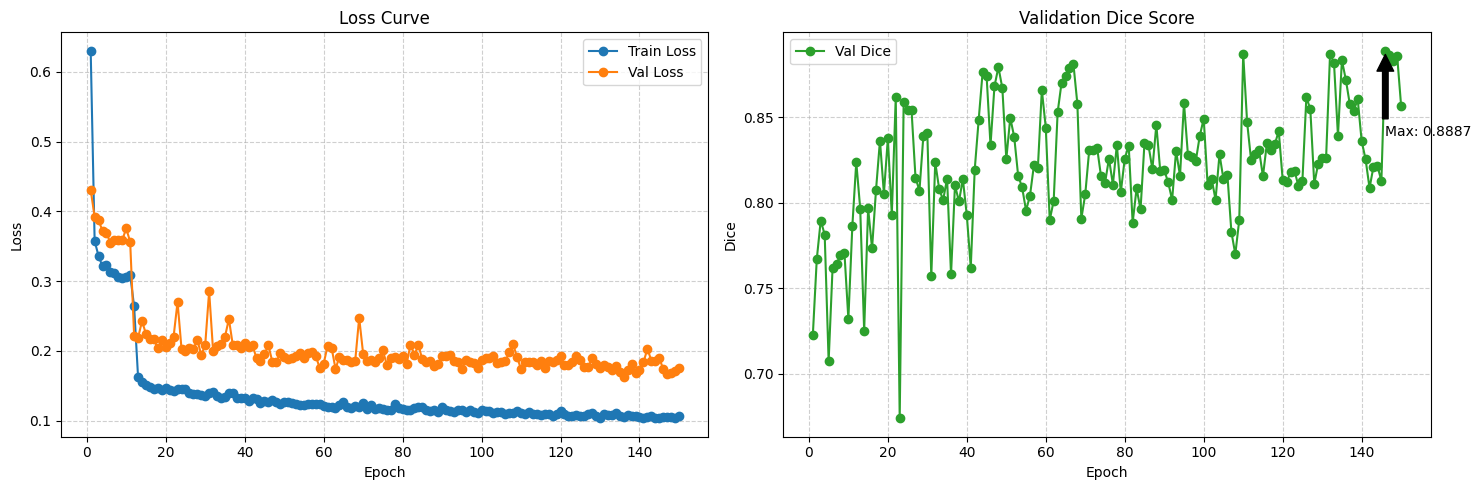

Epoch 150 | T-Loss: 0.1074 | V-Loss: 0.1755 | V-Dice: 0.8565 (Best: 0.8887)
csv log: /home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_3img_256_DiceCELoss_200ep/rough_loss.csv
✅ Phase 1 Training Complete!


In [12]:
print("\n" + "="*40)
print("   🚀 START PHASE 1: PRE-TRAINING (ROUGH)")
print("   Target: 5 Classes (Rough Labels)")
print("="*40)
print(f"   📝 log will be saved to: {ROUGH_LOSS_LOG}")

# Setup Data (Mode='rough')
train_ds = SliceMasterDataset_Strategic25D( train_files, mode='rough', data_type='Train', transform=train_transform)
val_ds = SliceMasterDataset_Strategic25D(val_files, mode='rough', data_type='Val', transform=val_transform)
# DataLoaders
train_loader = DataLoader(train_ds, batch_size=ROUGH_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=ROUGH_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Phase 1 Data: {len(train_ds)} train slices, {len(val_ds)} val slices")

# 2. Setup Model (指定 n_classes=5)
model = ConditionedResNetUNet(
    n_channels=IN_CHANNELS,         # 3 (2.5D)
    n_classes_rough=NUM_CLASSES_ROUGH, 
    n_classes_detail=NUM_CLASSES_DETAILED, 
    embed_dim=EMBEDDING_DIM,
    num_mri_types=NUM_MRI_TYPES
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=ROUGH_LR)
# 在 Rough 階段，通常不需要特別強的 Class Weight，因為 Rough Label (大腿前側、後側等) 面積都蠻大的
criterion = DiceCELoss(num_classes=NUM_CLASSES_ROUGH, lambda_ce=1.0, lambda_dice=1.0).to(DEVICE)

scaler = torch.amp.GradScaler("cuda") # 混合精度訓練

# 3. Training Loop
best_dice = 0.0
history_rough = []

for epoch in range(ROUGH_EPOCHS):
    start_time = time.time()
    model.train()
    train_loss = 0
    
    # [Training]
    # 這裡解包 4 個變數: image, label, z_pos, type_idx
    for images, masks, z_pos, type_idx in tqdm(train_loader, desc=f"Epoch {epoch+1}/{ROUGH_EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
        
        with torch.amp.autocast("cuda"):
            # Forward
            preds = model(images, type_idx, z_pos, return_mode='rough')
            loss = criterion(preds, masks)
            
        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
    
    # [Validation]
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks, z_pos, type_idx in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
            
            with torch.amp.autocast("cuda"):
                preds = model(images, type_idx, z_pos, return_mode='rough')
                loss = criterion(preds, masks)
            
            val_loss += loss.item()
            # 計算 Dice (使用 Cell 2 定義的 function)
            val_dice += dice_score(preds, masks, NUM_CLASSES_ROUGH)
            
    # 計算平均指標
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    
    duration = time.time() - start_time
    
    # 紀錄歷史    
    history_rough.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_dice': avg_val_dice,
        'time': duration
    })
    pd.DataFrame(history_rough).to_csv(ROUGH_LOSS_LOG, index=False)
    
    # [Save Best Model] 關鍵步驟！
    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict, ROUGH_MODEL_PATH)
        print(f"  🏆 Saved Best Model! (Dice: {best_dice:.4f}) -> {ROUGH_MODEL_PATH}")
    
    plot_training_curves(ROUGH_LOSS_LOG, ROUGH_LOSS_IMG)
    print(f"Epoch {epoch+1} | T-Loss: {avg_train_loss:.4f} | V-Loss: {avg_val_loss:.4f} | V-Dice: {avg_val_dice:.4f} (Best: {best_dice:.4f})")
    print(f"csv log: {ROUGH_LOSS_LOG}")
    
print("✅ Phase 1 Training Complete!")

### 6. Phase 1.5: Hierarchical Warm-up

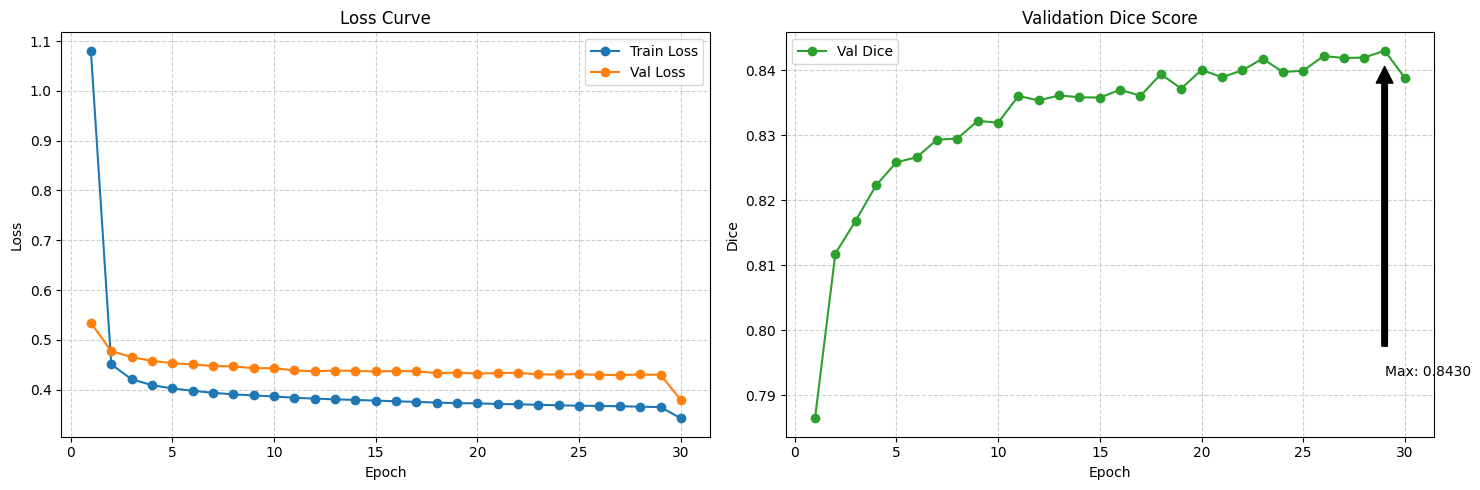

Warmup 30 | Train Loss: 0.3422 | Val Loss: 0.3793 (CE: 0.3714, Consist: 0.0158)
csv log: /home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_3img_256_DiceCELoss_200ep/warmup_loss.csv
Phase 1.5 Complete. Detail Head Initialized.


In [13]:
print("\n" + "="*40)
print("   🚀 START PHASE 1.5: HIERARCHICAL WARM-UP")
print("   Goal: Train Detail Head to align with Rough Head")
print("="*40)
print(f"   📝 log will be saved to: {WARMUP_LOSS_LOG}")

# 1. 資料過濾 (只用有 Detail 的資料)
print("Filtering detailed data...")
train_files_detail = [f for f in train_files if np.load(f, allow_pickle=True).item().get('has_detail', False)]
val_files_detail = [f for f in val_files if np.load(f, allow_pickle=True).item().get('has_detail', False)]
print(f"Detail Train: {len(train_files_detail)} | Detail Val: {len(val_files_detail)}")

# Setup Data (Mode='detail')
train_ds_warmup = SliceMasterDataset_Strategic25D( train_files_detail, mode='detail', data_type='Train', transform=train_transform)
val_ds_warmup = SliceMasterDataset_Strategic25D( val_files_detail, mode='detail', data_type='Val', transform=val_transform)
# DataLoaders
train_loader_warmup = DataLoader(train_ds_warmup, batch_size=WARMUP_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader_warmup = DataLoader(val_ds_warmup, batch_size=WARMUP_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = ConditionedResNetUNet(
    n_channels=IN_CHANNELS, 
    n_classes_rough=NUM_CLASSES_ROUGH, 
    n_classes_detail=NUM_CLASSES_DETAILED, 
    embed_dim=EMBEDDING_DIM,
    num_mri_types=NUM_MRI_TYPES
).to(DEVICE)

# 3. 載入 Phase 1 權重
model.load_pretrained_encoder(ROUGH_MODEL_PATH)

# 4. 凍結 Encoder 和 Rough Head (老師不准動)
model.freeze_encoder_and_rough()

    
# 5. 定義帶權重的 Loss (Crucial for AM Muscle!)
# 0:BG, 6:AM -> 加強 AM 權重
warmup_weights = torch.ones(NUM_CLASSES_DETAILED).to(DEVICE)
warmup_weights[6] = 2.0 
criterion_warmup = DiceCELoss(
    num_classes=NUM_CLASSES_DETAILED, 
    weight=warmup_weights, 
    lambda_ce=1.0, 
    lambda_dice=1.0
).to(DEVICE)

# 6. Optimizer (只更新 head_detail)
optimizer_warmup = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=WARMUP_LR)
scaler = torch.amp.GradScaler("cuda") # 混合精度訓練

best_warmup_dice = 0.0
history_warmup = []

# 7. Training Loop (Warm-up)
print(f"🔥 Starting Warm-up for {WARMUP_EPOCHS} epochs...")
for epoch in range(WARMUP_EPOCHS): # 短暫訓練即可 (e.g., 5-10 epochs)
    model.train()
    train_loss = 0
    train_loss_ce = 0
    train_loss_consist = 0
    
    pbar = tqdm(train_loader_warmup, desc=f"Warm-up Epoch {epoch+1}/{WARMUP_EPOCHS}")
    
    for images, mask_detail, z_pos, type_idx in pbar:
        images, mask_detail = images.to(DEVICE), mask_detail.to(DEVICE)
        z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
        
        with torch.amp.autocast("cuda"):
            # Forward (取得兩組 Logits)
            logits_rough, logits_detail = model(images, type_idx, z_pos, return_mode='both')
            
            # Loss 1: Detailed Head 要預測正確 (Cross Entropy)
            loss_ce = criterion_warmup(logits_detail, mask_detail)
            
            with torch.no_grad():
                # Loss 2: Consistency Constraint (Student -> Teacher)
                # 這裡我們信任 Rough Head 的判斷 (因為它是 Phase 1 訓練好的老師)
                teacher_logits = logits_rough 
            loss_consist = hierarchical_consistency_loss(logits_detail, teacher_logits)
            
            # Total Loss
            loss = loss_ce + CONSISTENCY_WEIGHT * loss_consist 
            
        optimizer_warmup.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer_warmup)
        scaler.update()
        
        # 記錄數據
        train_loss += loss.item()
        train_loss_ce += loss_ce.item()
        train_loss_consist += loss_consist.item()
        
        pbar.set_postfix({'L': loss.item(), 'CE': loss_ce.item(), 'C': loss_consist.item()})

    avg_train_loss = train_loss / len(train_loader_warmup)

    # --- [Validation] ---
    model.eval()
    val_loss = 0
    val_loss_ce = 0
    val_loss_consist = 0
    val_dice = 0
    
    with torch.no_grad():
        for images, masks, z_pos, type_idx in val_loader_warmup:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
            
            with torch.amp.autocast("cuda"):
                logits_rough, logits_detail = model(images, type_idx, z_pos, return_mode='both')
                
                l_ce = criterion_warmup(logits_detail, masks)
                l_consist = hierarchical_consistency_loss(logits_detail, logits_rough)
                l_total = l_ce + CONSISTENCY_WEIGHT * l_consist
            
            val_loss += l_total.item()
            val_loss_ce += l_ce.item()
            val_loss_consist += l_consist.item()
            preds = model(images, type_idx, z_pos, return_mode='detail')
            val_dice += dice_score(preds, masks, NUM_CLASSES_DETAILED)
            
    avg_val_loss = val_loss / len(val_loader_warmup)
    avg_val_ce = val_loss_ce / len(val_loader_warmup)
    avg_val_consist = val_loss_consist / len(val_loader_warmup)
    avg_val_dice = val_dice / len(val_loader_warmup)
    
    # 紀錄歷史
    history_warmup.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_ce': avg_val_ce,
        'val_consist': avg_val_consist,
        'val_dice': avg_val_dice
    })
    # 儲存最佳模型
    if avg_val_dice > best_warmup_dice:
        best_warmup_dice = avg_val_dice
        state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict, WARMUP_MODEL_PATH)
        print(f"   🏆 Saved Best Warmup Model! (Dice: {best_warmup_dice:.4f})")
        
    pd.DataFrame(history_warmup).to_csv(WARMUP_LOSS_LOG, index=False)
    plot_training_curves(WARMUP_LOSS_LOG, WARMUP_LOSS_IMG)
        
    print(f"Warmup {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} (CE: {avg_val_ce:.4f}, Consist: {avg_val_consist:.4f})")
    print(f"csv log: {WARMUP_LOSS_LOG}")

# 存下 Warm-up 後的權重，給 Step 2 用
state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
torch.save(state_dict, WARMUP_MODEL_PATH)
print("Phase 1.5 Complete. Detail Head Initialized.")

### 7. Phase 2: Fine-tune

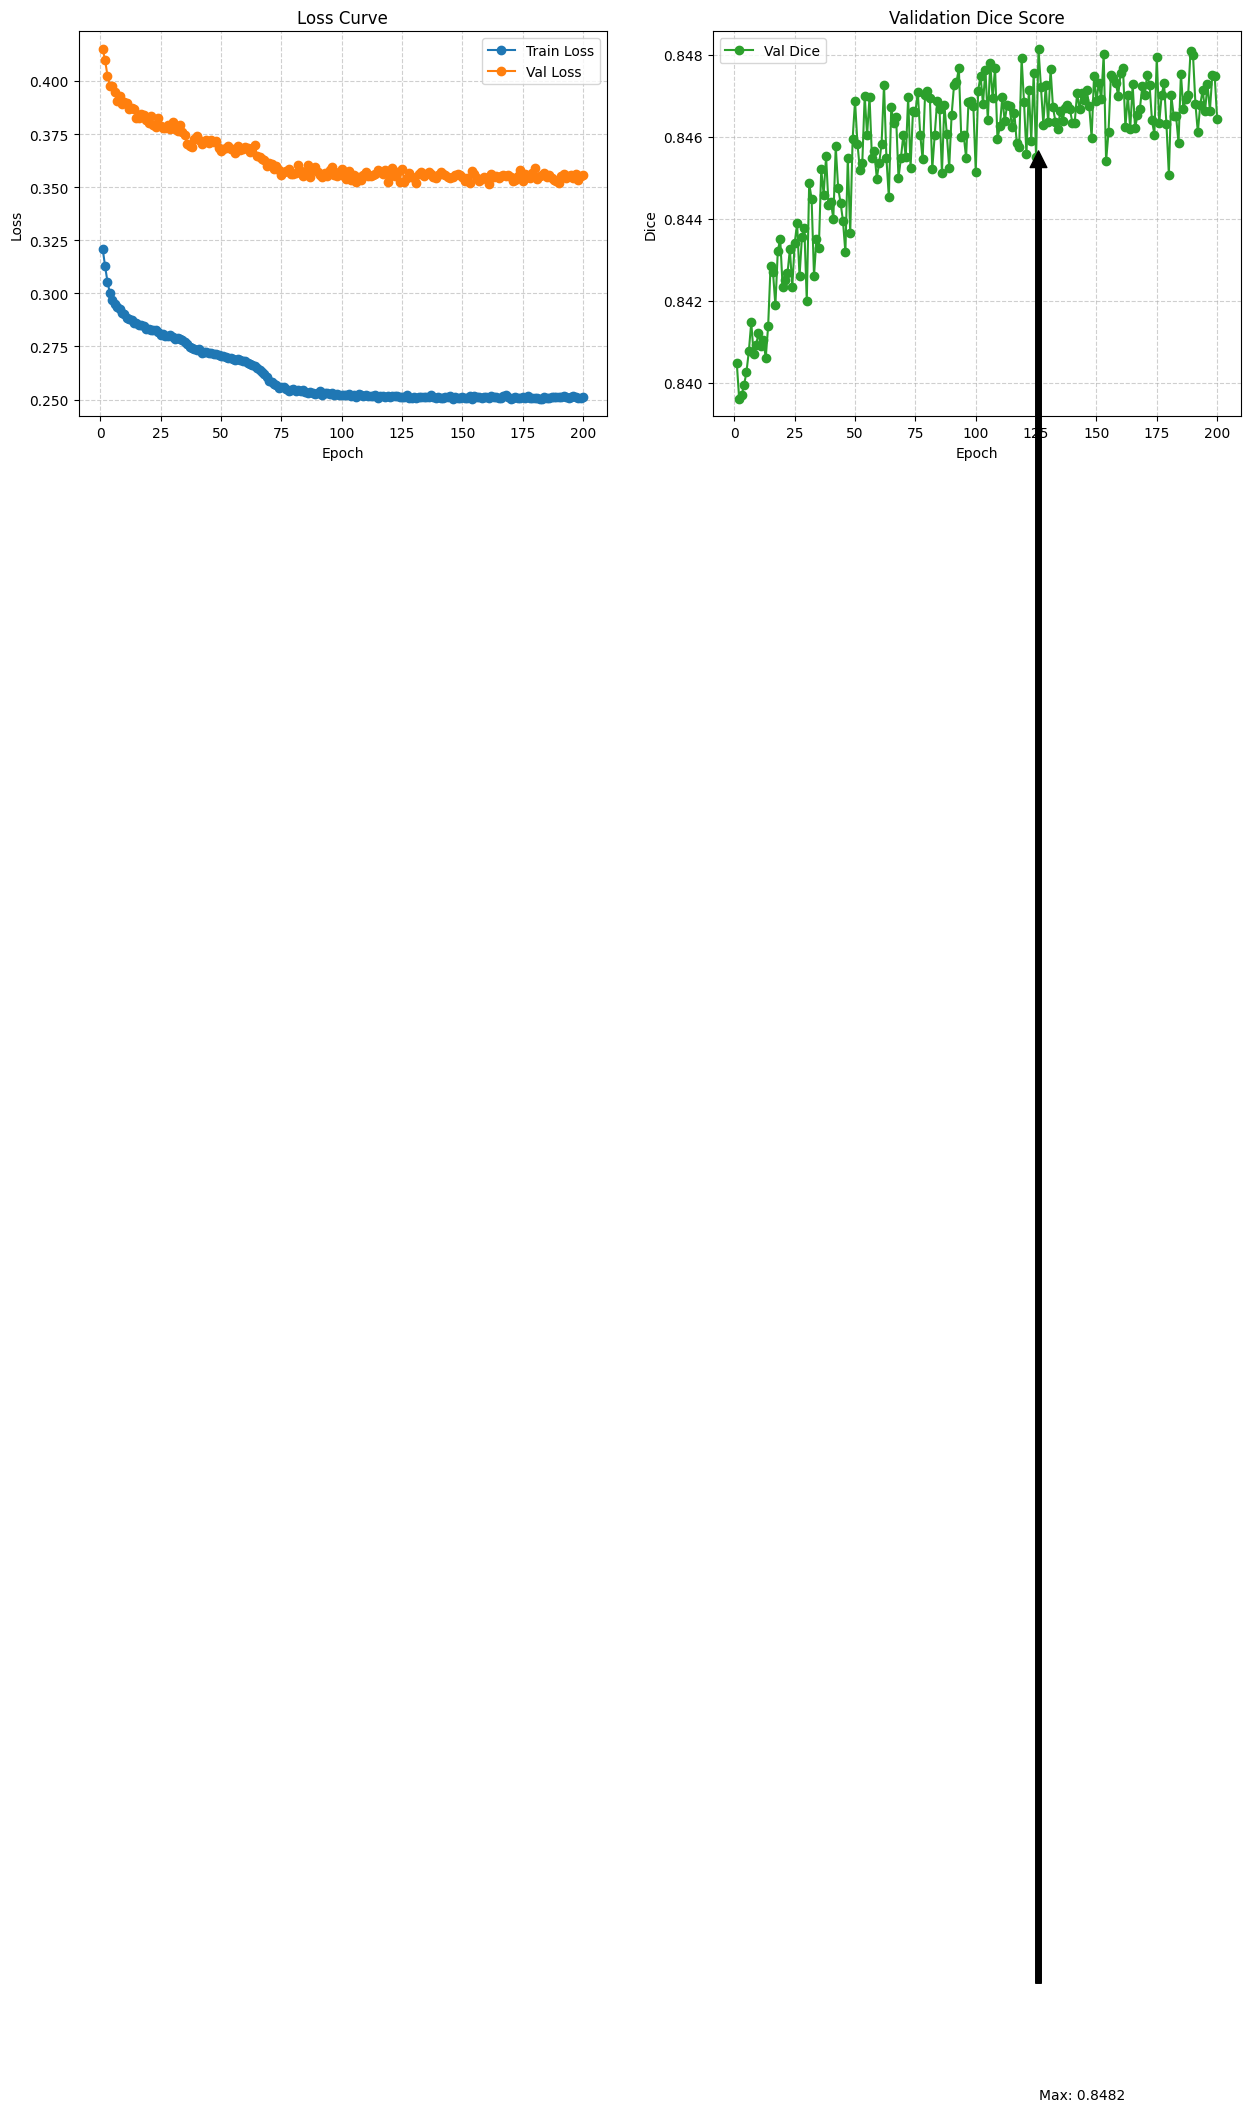

Epoch 200 | T-Loss: 0.2512 | V-Loss: 0.3558 | V-Dice: 0.8464 | Time: 18.7s
csv log: /home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_3img_256_DiceCELoss_200ep/detail_loss.csv
Phase 2 Complete.


In [14]:
print("\n" + "="*40)
print("   🚀 START PHASE 2: FINE-TUNING (DETAIL)")
print(f"   Target: {NUM_CLASSES_DETAILED} Classes (Detailed Labels)")
print("="*40)
print(f"   📝 log will be saved to: {DETAIL_LOSS_LOG}")

# 1. 資料過濾 (只用有 Detail 的資料)
print("Filtering detailed data...")
train_files_detail = [f for f in train_files if np.load(f, allow_pickle=True).item().get('has_detail', False)]
val_files_detail = [f for f in val_files if np.load(f, allow_pickle=True).item().get('has_detail', False)]
print(f"Detail Train: {len(train_files_detail)} | Detail Val: {len(val_files_detail)}")

# Setup Data (Mode='detail')
train_ds_detail = SliceMasterDataset_Strategic25D( train_files_detail, mode='detail', data_type='Train', transform=train_transform)
val_ds_detail = SliceMasterDataset_Strategic25D( val_files_detail, mode='detail', data_type='Val', transform=val_transform)
# DataLoaders
train_loader_detail = DataLoader(train_ds_detail, batch_size=DETAIL_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader_detail = DataLoader(val_ds_detail, batch_size=DETAIL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# 2. Setup Model (12 Classes)
model = ConditionedResNetUNet(
    n_channels=IN_CHANNELS, 
    n_classes_rough=NUM_CLASSES_ROUGH, 
    n_classes_detail=NUM_CLASSES_DETAILED, 
    embed_dim=EMBEDDING_DIM,
    num_mri_types=NUM_MRI_TYPES
).to(DEVICE)

# 3. Load Pretrained Weights (Surgery)
if os.path.exists(WARMUP_MODEL_PATH):
    print(f"🔄 Loading pretrained weights from: {WARMUP_MODEL_PATH}")
    # model.load_state_dict(torch.load(WARMUP_MODEL_PATH))
    model.load_state_dict(torch.load(WARMUP_MODEL_PATH))
    print("✅ Weights loaded from Phase 1.5")
else:
    raise FileNotFoundError(f"❌ Phase 1.5 model not found at {WARMUP_MODEL_PATH}.")

# [關鍵] 全面解凍 (因為 Phase 1.5 結束時是凍結的)
model.unfreeze_all()

# ==========================================
# 4. Optimizer_detail & Weighted Loss
# ==========================================
optimizer_detail = get_fine_tuning_optimizer(model, encoder_lr=DETAIL_LR_ENCODER, decoder_lr=DETAIL_LR_DECODER)
# [關鍵策略] Class Weighting
# 因為 AM (Class 6) 之前被當作背景，我們要給它更高的權重，強迫模型關注它
# 0:BG, 1:SA, ..., 6:AM, ...
class_weights = torch.ones(NUM_CLASSES_DETAILED).to(DEVICE)
class_weights[0] = 0.5  # Background 降權
class_weights[6] = 3.0  # AM (最難切，給最高權重)
class_weights[1] = 2.5  # Sar (細長表淺)
class_weights[7] = 2.5  # Gra (細長帶狀)
class_weights[9] = 2.0  # BFSH (表現稍弱)

criterion_detail = DiceCELoss(
    num_classes=NUM_CLASSES_DETAILED, 
    weight=class_weights, 
    lambda_ce=1.0, 
    lambda_dice=1.0
).to(DEVICE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_detail, mode='max', factor=0.5, patience=10)
scaler = torch.amp.GradScaler("cuda") # 混合精度訓練

# ==========================================
# 5. Training Loop
# ==========================================
best_dice = 0.0
history_detail = []
print(f"Start Fine-tuning for {DETAIL_EPOCHS} epochs...")

for epoch in range(DETAIL_EPOCHS):
    start_time = time.time()
    model.train()
    train_loss = 0
    
    # [Training]
    pbar = tqdm(train_loader_detail, desc=f"Epoch {epoch+1}/{DETAIL_EPOCHS}")
    
     # 這裡解包 4 個變數: image, label, z_pos, type_idx
    for images, masks, z_pos, type_idx in pbar:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
        
        with torch.amp.autocast("cuda"):
            preds = model(images, type_idx, z_pos, return_mode='detail')
            loss = criterion_detail(preds, masks)
            
        optimizer_detail.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer_detail)
        scaler.update()
        
        train_loss += loss.item()
        
    # [Validation]
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks, z_pos, type_idx in val_loader_detail:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            z_pos, type_idx = z_pos.to(DEVICE), type_idx.to(DEVICE)
                        
            with torch.amp.autocast("cuda"):
                preds = model(images, type_idx, z_pos, return_mode='detail')
                loss = criterion_detail(preds, masks)
            
            val_loss += loss.item()
            # 這裡計算 12 類的 Dice
            val_dice += dice_score(preds, masks, NUM_CLASSES_DETAILED)
            
    avg_train_loss = train_loss / len(train_loader_detail)
    avg_val_loss = val_loss / len(val_loader_detail)
    avg_val_dice = val_dice / len(val_loader_detail)
    
    scheduler.step(avg_val_dice)
    curr_lr = optimizer_detail.param_groups[1]['lr'] # Decoder LR
    duration = time.time() - start_time
    # 紀錄歷史
    history_detail.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_dice': avg_val_dice,
        'lr_decoder': curr_lr,
        'time': duration
    })
    pd.DataFrame(history_detail).to_csv(DETAIL_LOSS_LOG, index=False)
    plot_training_curves(DETAIL_LOSS_LOG, DETAIL_LOSS_IMG)
    print(f"Epoch {epoch+1} | T-Loss: {avg_train_loss:.4f} | V-Loss: {avg_val_loss:.4f} | V-Dice: {avg_val_dice:.4f} | Time: {duration:.1f}s")
    print(f"csv log: {DETAIL_LOSS_LOG}")
    
    
    # [Save Best]
    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict, DETAIL_MODEL_PATH)
        print(f"  🏆 Saved Best Detail Model! (Dice: {best_dice:.4f})")

print("Phase 2 Complete.")

### 8. Test

In [15]:
def predict_with_pixel_tta(model, images, type_idx, z_pos, tta_times=8, transform=None, return_mode='detail'):
    """
    Monte Carlo TTA (Test Time Augmentation):
    針對 2.5D 輸入 (3 Channels) 的每一層做「獨立」的像素增強 (亮度、雜訊、Gamma等)，
    重複多次預測並取平均，能有效提升對抗 STIR 雜訊的魯棒性。
    """
    model.eval()
    
    # 0. TTA 目前僅支援 Batch Size = 1 (逐張處理)
    if images.size(0) != 1:
        raise ValueError("TTA currently supports Batch Size = 1 only.")

    accumulated_probs = None
    
    # 1. 準備基底影像 (Tensor -> Numpy HWC)
    # images: (1, 3, H, W) -> squeeze -> (3, H, W) -> transpose -> (H, W, 3)
    # 確保是 float32 且在 CPU
    img_base = images.squeeze(0).cpu().numpy().transpose(1, 2, 0).astype(np.float32)

    # 2. TTA 迴圈: 跑 1 次原圖 + tta_times 次增強圖
    total_runs = tta_times + 1
    
    for i in range(total_runs):
        if i == 0:
            # --- 第 0 次：Baseline (原圖) ---
            # 這是最重要的一次，確保模型至少看過乾淨的原始影像
            input_tensor = images
        else:
            # --- 第 1~N 次：加入隨機干擾 ---
            aug_channels = []
            
            if transform:
                # [關鍵] 拆開 3 個 Channel，對每個 Channel "獨立" 做 Transform
                for c in range(3):
                    ch = img_base[:, :, c] # shape: (H, W)
                    
                    # Albumentations 處理 2D 陣列
                    # transform 內部包含隨機性 (p=0.5 等)，所以每次結果都不一樣
                    aug_ch = transform(image=ch)['image']
                    aug_channels.append(aug_ch)
                
                # 堆疊回去 -> (H, W, 3)
                img_aug = np.stack(aug_channels, axis=-1)
            else:
                img_aug = img_base.copy()
            
            # Numpy -> Tensor (1, 3, H, W)
            input_tensor = torch.from_numpy(img_aug.transpose(2, 0, 1))
            input_tensor = input_tensor.unsqueeze(0).float().to(DEVICE)

        # 3. 模型推論
        with torch.no_grad():
            with torch.amp.autocast("cuda"):
                # 注意：z_pos 和 type_idx 保持不變 (MetaData 不受像素增強影響)
                logits = model(input_tensor, type_idx, z_pos, return_mode= return_mode)
                probs = torch.softmax(logits, dim=1)
        
        # 4. 累加機率
        if accumulated_probs is None:
            accumulated_probs = probs
        else:
            accumulated_probs += probs

    # 5. 取平均
    avg_probs = accumulated_probs / total_runs
    
    return avg_probs

Found 724 slices in Test Set.
  - With Detailed Labels: 618 slices
  - Without Detailed Labels: 106 slices


Building Index: 100%|██████████| 618/618 [00:00<00:00, 4235.94it/s]


🔄 Loading weights from: /home/n26141826/114-1_TAICA_cv_Final_Project/checkpoints/checkpoints_3step_3img_256_DiceCELoss_200ep/detail_model_best.pth
🚀 Starting Inference on Test Set...


100%|██████████| 618/618 [00:15<00:00, 38.72it/s]


   Test Set Evaluation Report (Dice Score)
數值為 Mean Dice Score:


,Fat,STIR,T1,T2,Water
Adductor Magnus,0.8152,0.7073,0.8088,0.8082,0.8029
Biceps Femoris LH,0.7822,0.7715,0.8361,0.7706,0.7797
Biceps Femoris SH,0.7923,0.7110,0.7895,0.7999,0.7855
Gracilis,0.8268,0.6943,0.8162,0.8269,0.8277
Rectus Femoris,0.8324,0.6108,0.7808,0.8284,0.8513
Sartorius,0.8261,0.7841,0.8470,0.8592,0.8300
Semimembranosus,0.7341,0.6924,0.8080,0.7374,0.7410
Semitendinosus,0.7352,0.7081,0.7881,0.7968,0.7363
Vastus Intermedius,0.7630,0.7915,0.8227,0.7952,0.7922
Vastus Lateralis,0.8293,0.8178,0.8623,0.8425,0.8493



評估表已儲存至: /home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_3img_256_DiceCELoss_200ep/evaluation_metrics_per_sequence.csv

Sampled every 50 slices from Test Set


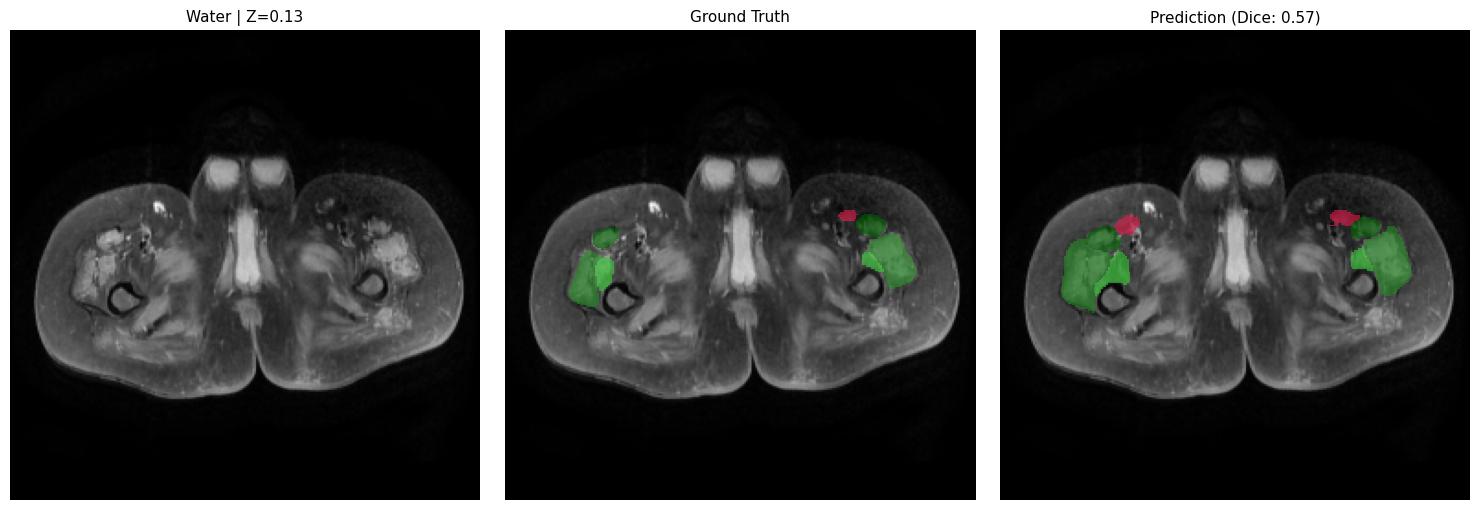

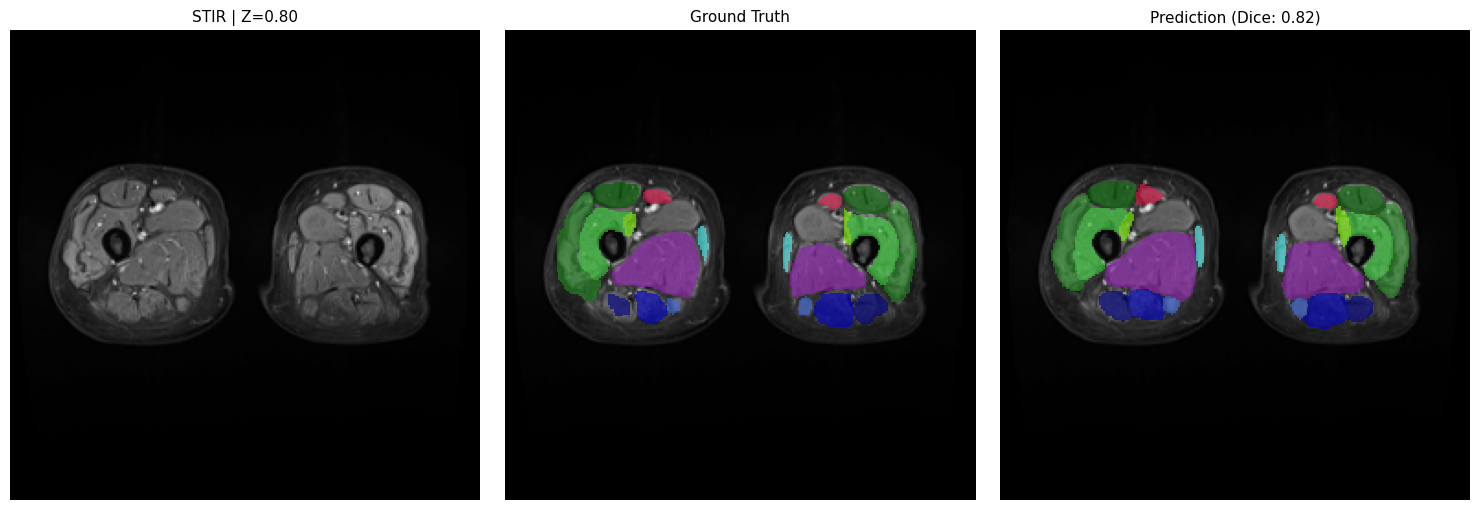

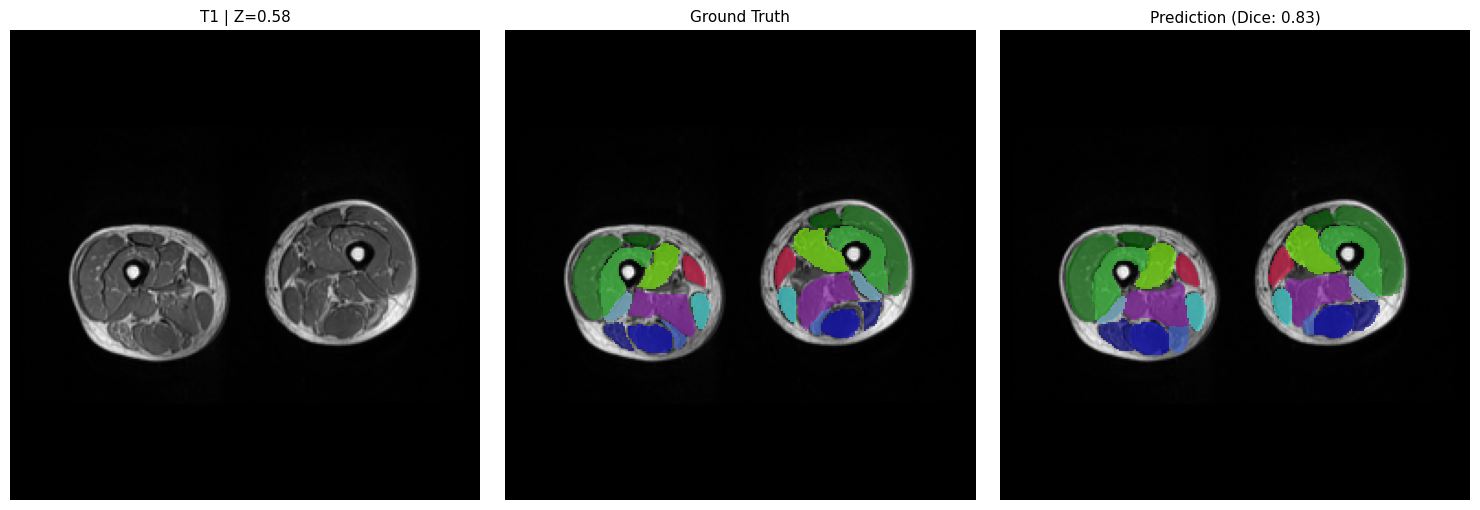

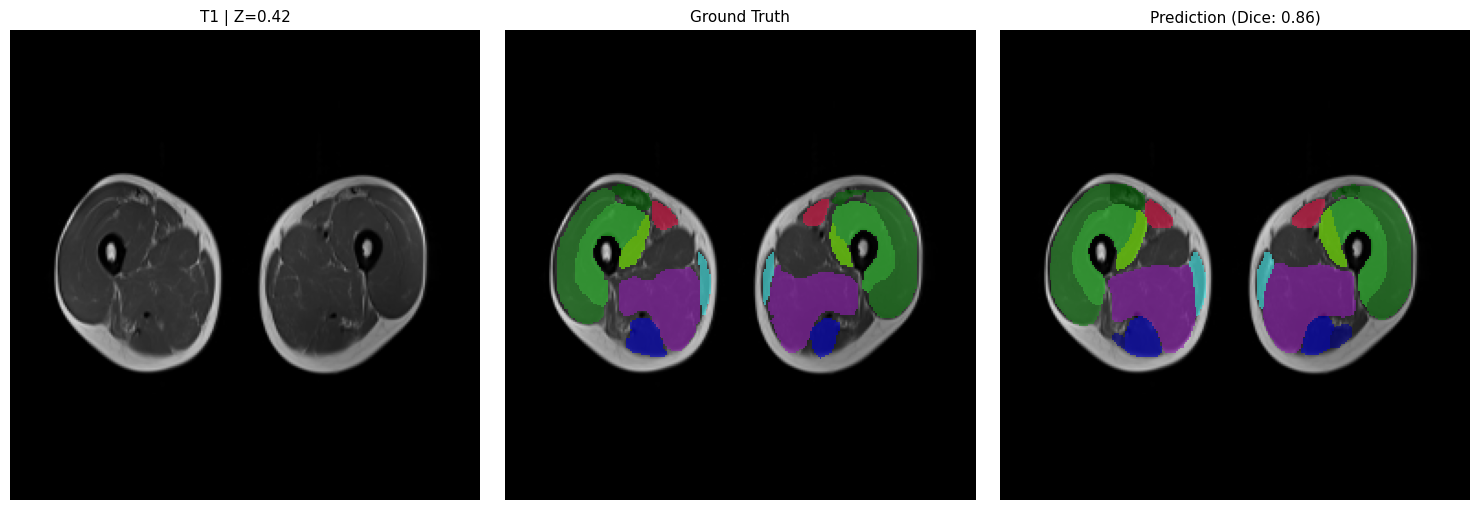

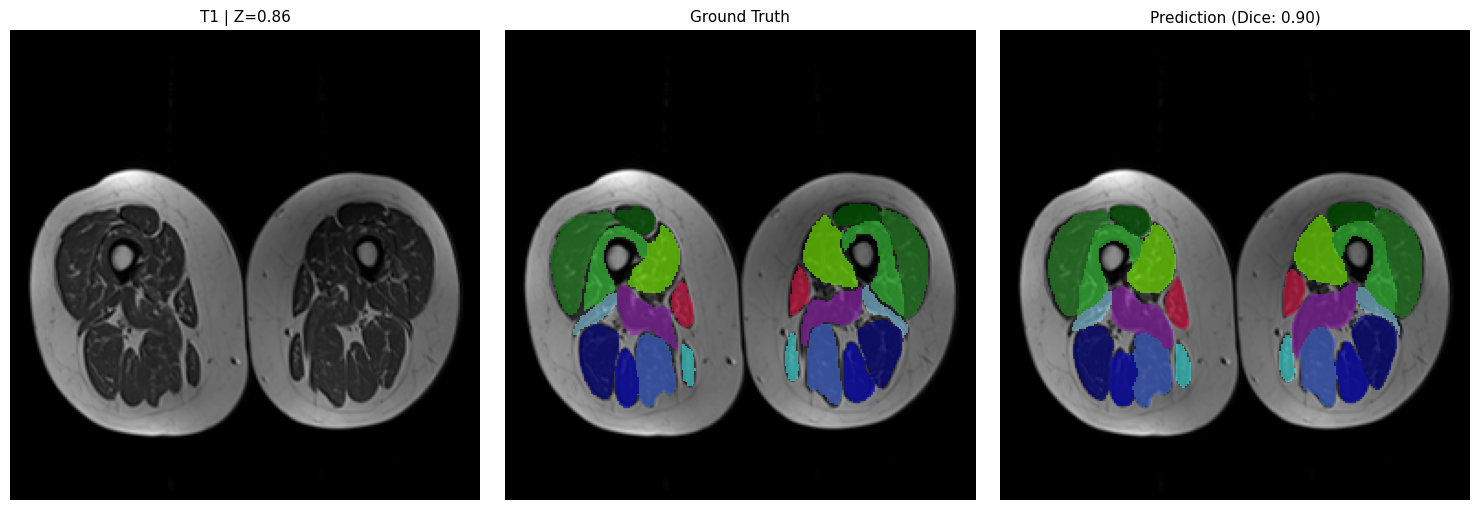

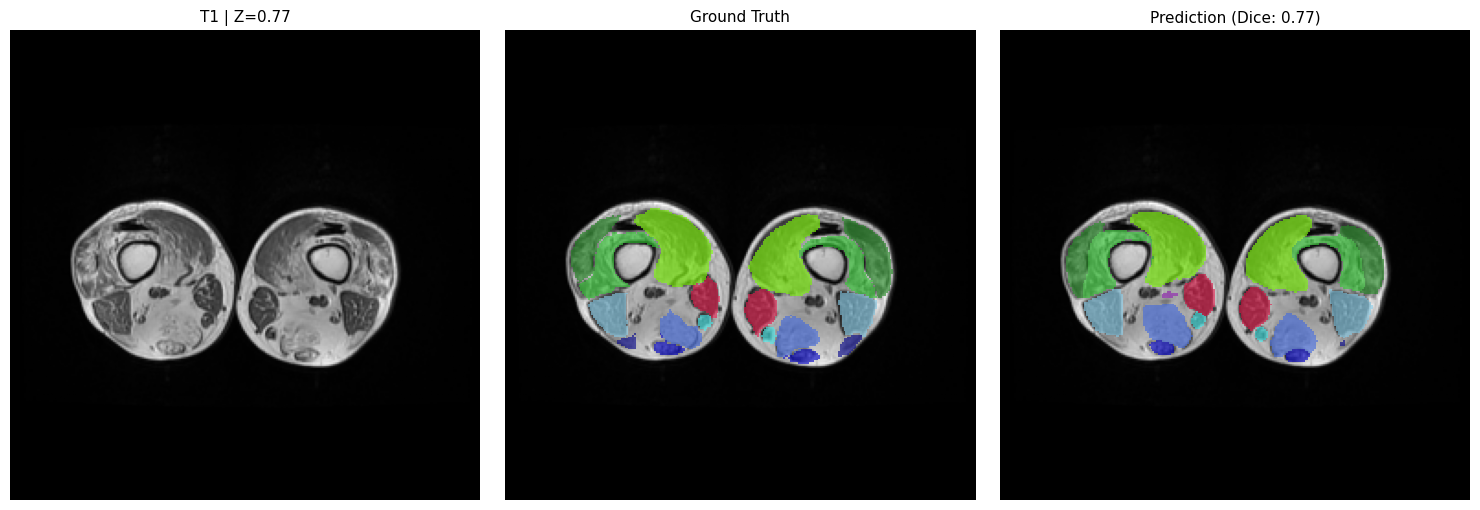

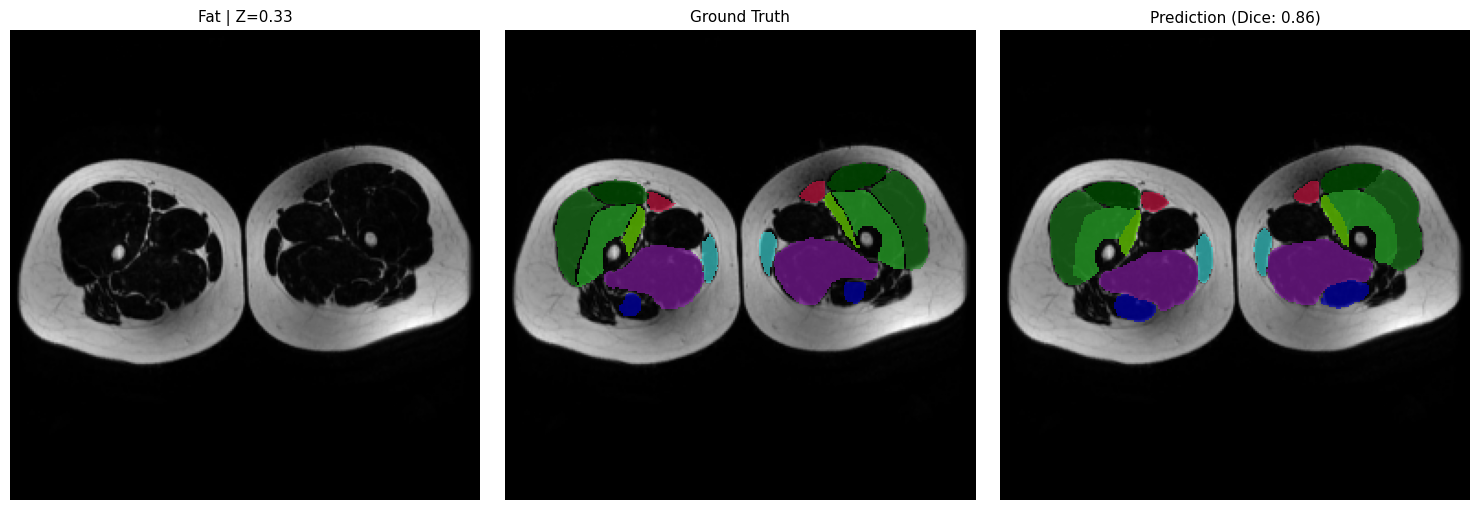

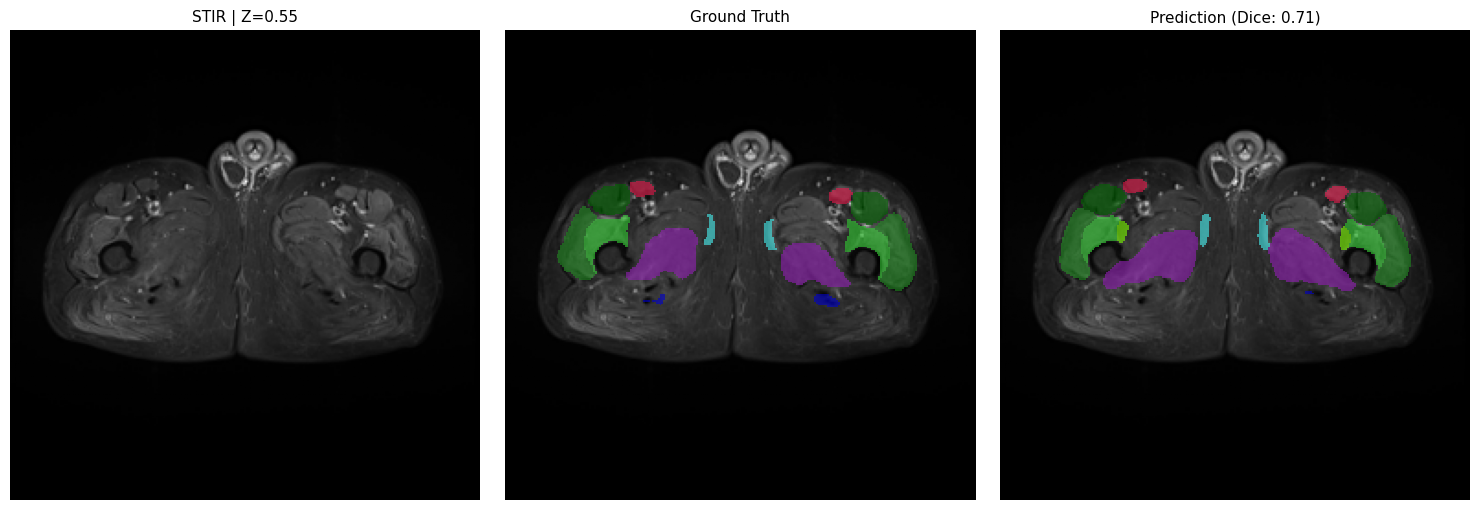

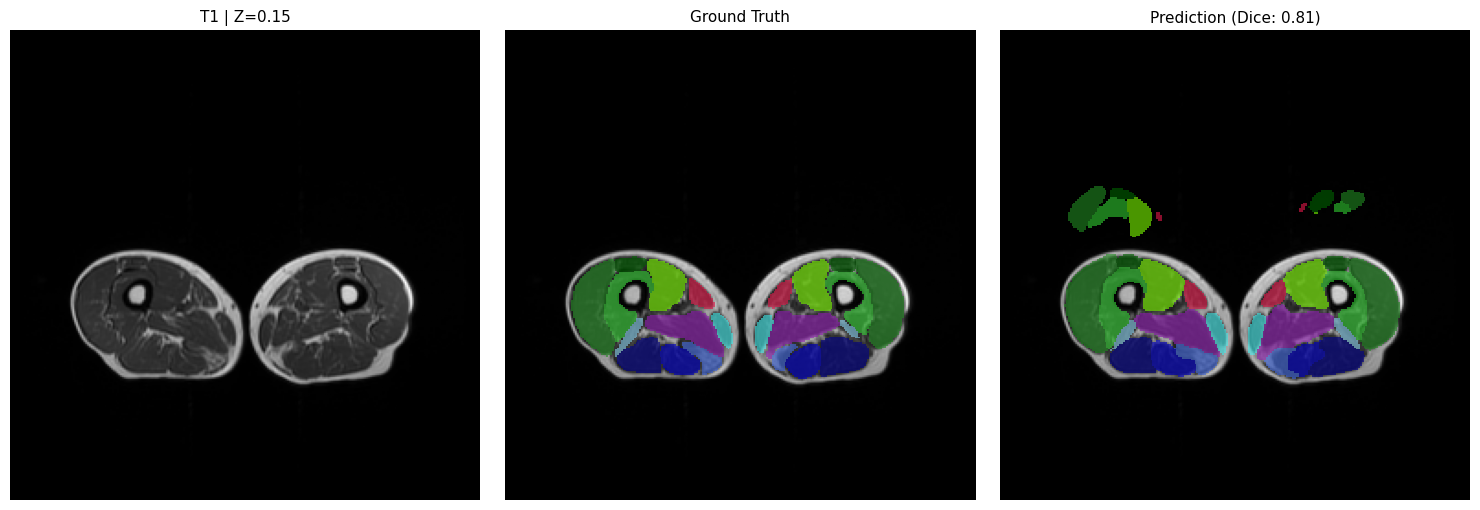

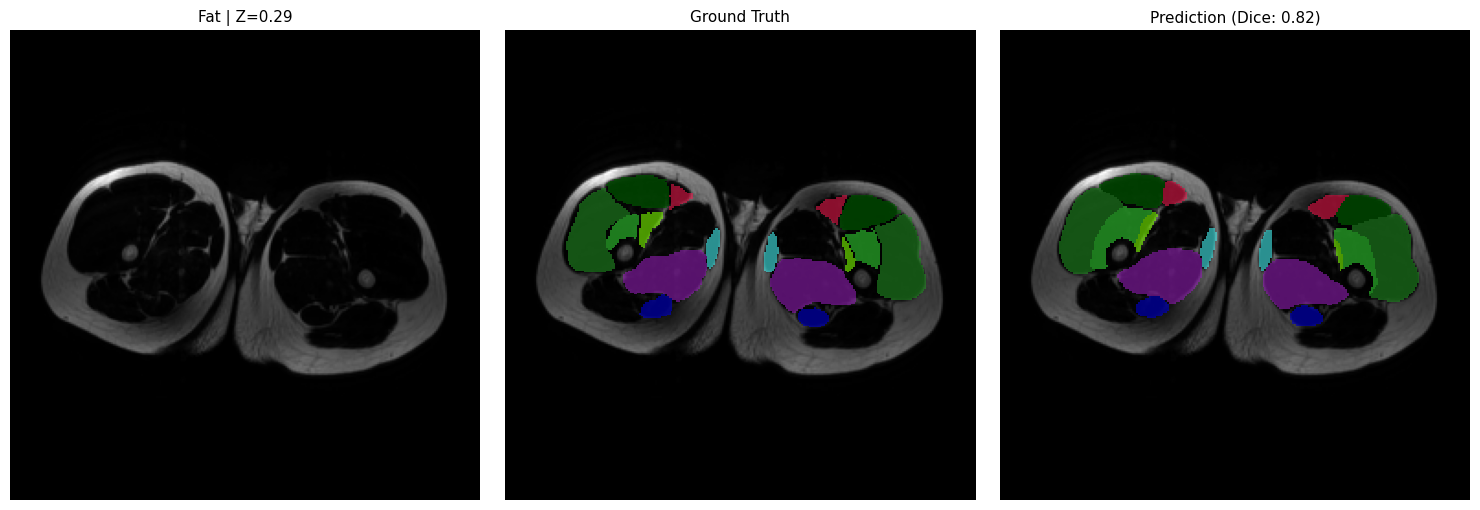

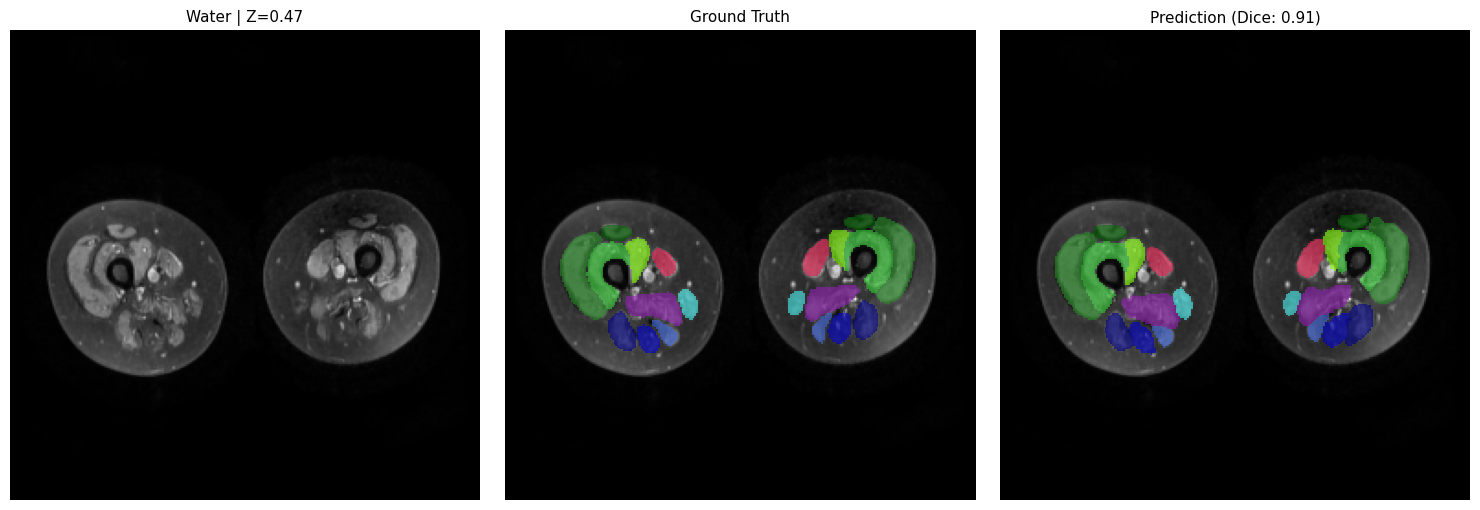

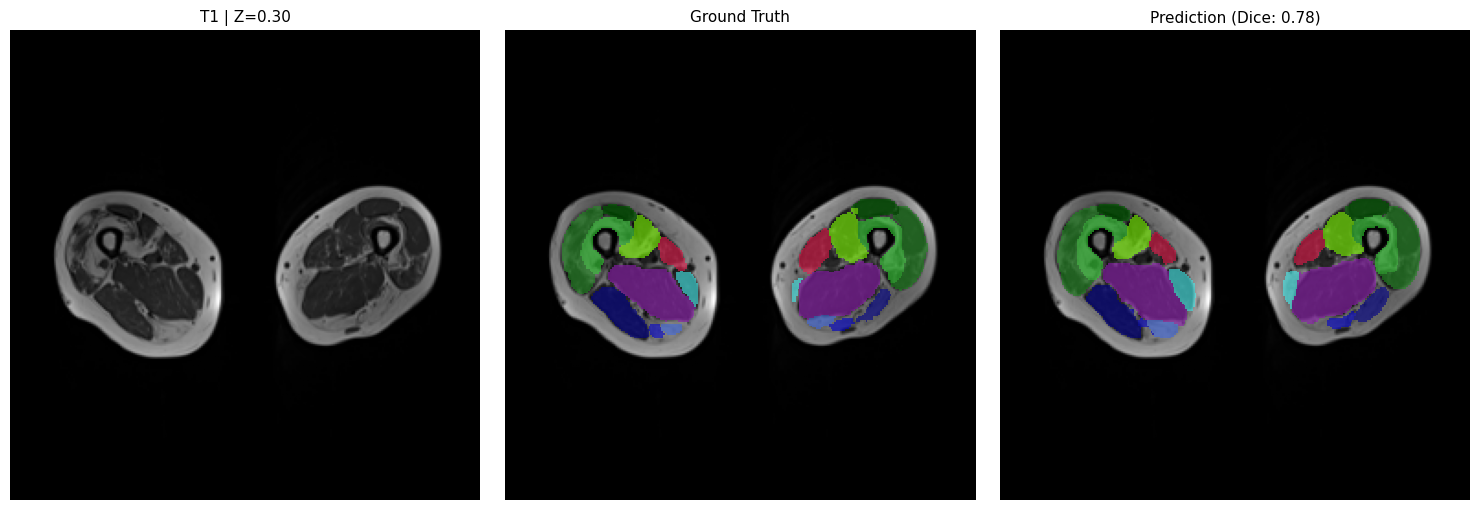

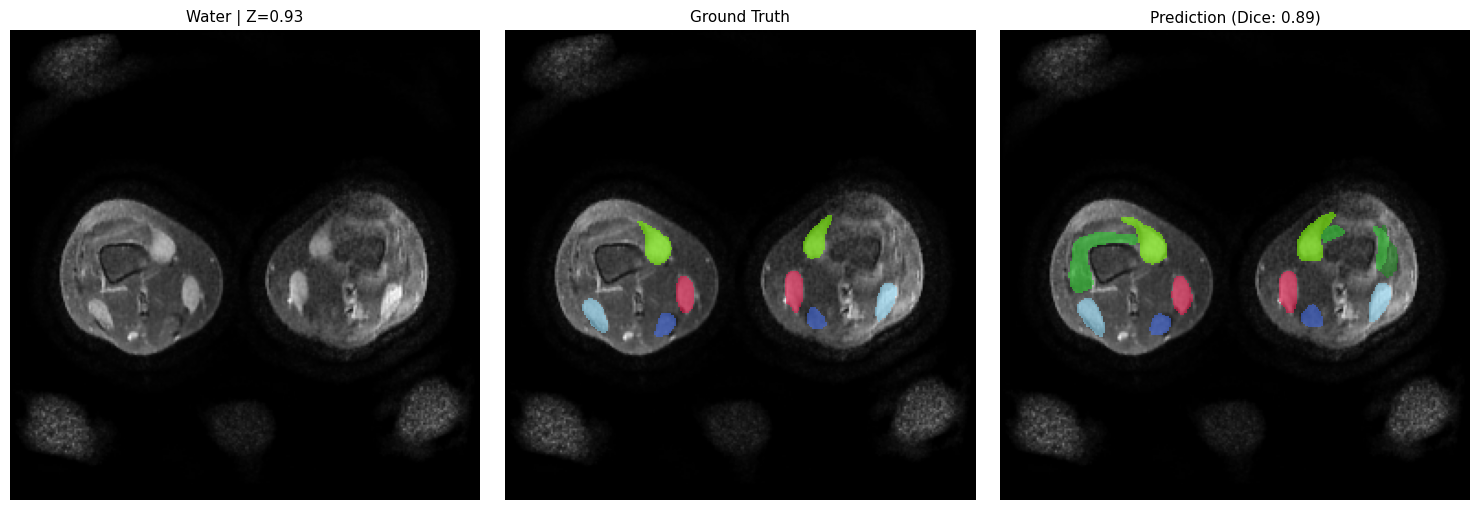

In [16]:
test_files = glob.glob(os.path.join(TEST_DATA_DIR, "*.npy"))
if len(test_files) == 0:
    raise FileNotFoundError(f"❌ No .npy files found in {TEST_DATA_DIR}. Please check the path!")

print(f"Found {len(test_files)} slices in Test Set.")
test_detail = []
test_without_detail = []
for i in test_files:
    data = np.load(i, allow_pickle=True).item()
    if data.get('has_detail'):
        test_detail.append(i)
    else:
        test_without_detail.append(i)
print(f"  - With Detailed Labels: {len(test_detail)} slices")
print(f"  - Without Detailed Labels: {len(test_without_detail)} slices")

# Setup Data (Mode='detail')
test_ds = SliceMasterDataset_Strategic25D( test_detail, mode='detail', data_type='Test', transform=val_transform)
# DataLoaders
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

# ==========================================
# 2. 載入模型
# ==========================================
model = ConditionedResNetUNet(
    n_channels=IN_CHANNELS, 
    n_classes_rough=NUM_CLASSES_ROUGH, 
    n_classes_detail=NUM_CLASSES_DETAILED, 
    embed_dim=EMBEDDING_DIM,
    num_mri_types=NUM_MRI_TYPES
).to(DEVICE)

if os.path.exists(EVAL_MODEL_PATH):
    print(f"🔄 Loading weights from: {EVAL_MODEL_PATH}")
    state_dict = torch.load(EVAL_MODEL_PATH, map_location=DEVICE, weights_only=False)
    model.load_state_dict(state_dict)
else:
    raise FileNotFoundError(f"❌ Model weight not found at {EVAL_MODEL_PATH}")
model.eval()

# ================= 3. 推論與數據收集 =================
# 儲存結構: metrics[Sequence][Muscle_ID] = [dice1, dice2, ...]
metrics_data = defaultdict(lambda: defaultdict(list))
viz_results = []  # 儲存要畫圖的資料
print("🚀 Starting Inference on Test Set...")

with torch.no_grad():
    for idx, (images, labels, z_pos, type_idx) in enumerate(tqdm(test_loader)):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        z_pos = z_pos.to(DEVICE)
        type_idx = type_idx.to(DEVICE)
        
        # 取得當前的 MRI Type ID
        current_type_id = type_idx[0, 1].item()
        current_z_pos = z_pos[0, 1].item()
        
        # 推論 (return_mode='detail')
        
        with torch.amp.autocast("cuda"):
            out_det = model(images, type_idx, z_pos, return_mode='detail')
            
        pred_det = torch.argmax(out_det, dim=1)
        # --- 使用 TTA 預測 ---
        # probs = predict_with_pixel_tta(
        #     model, images, type_idx, z_pos, 
        #     tta_times=8, 
        #     transform=val_transform,
        #     return_mode='detail'
        # )
        # pred_det = torch.argmax(probs, dim=1)
        
        # --- 計算每個肌肉的 Dice 並存起來 ---
        slice_dices = []
        for c in range(1, NUM_CLASSES_DETAILED): # 1~11 (Skip BG)
            pred_mask = (pred_det == c)
            true_mask = (labels == c)
            
            inter = (pred_mask & true_mask).sum().item()
            union = (pred_mask.sum() + true_mask.sum()).item()
            
            # 只有當 GT 有該肌肉時才納入統計
            if true_mask.sum() > 0:
                dice_val = 2 * inter / (union + 1e-6)
                metrics_data[current_type_id][c].append(dice_val)
                slice_dices.append(dice_val)
            
        # --- 收集視覺化資料 (隨機抽樣) ---
        if idx % VIZ_INTERVAL == 0:
            avg_slice_dice = np.mean(slice_dices) if slice_dices else 0.0
            type_name = ID_TO_TYPE.get(current_type_id, str(current_type_id))
            
            viz_results.append({
                'type_name': type_name,
                'z': z_pos[0, 1].item(),
                'img': images[0, 1].cpu().numpy(),
                'gt': labels[0].cpu().numpy(),
                'pred': pred_det[0].cpu().numpy(),
                'dice': avg_slice_dice
            })

# ================= 4. 產生報表 =================
# Rows: Muscle Names, Cols: Sequences

print("\n" + "="*40)
print("   Test Set Evaluation Report (Dice Score)")
print("="*40)

final_table = {}
all_types_in_data = sorted(metrics_data.keys())

for c in range(1, NUM_CLASSES_DETAILED):
    muscle_name = MUSCLE_NAMES.get(c, f"Muscle_{c}")
    row_data = {}
    for t_id in all_types_in_data:
        dices = metrics_data[t_id][c]
        mean_dice = np.mean(dices) if dices else 0.0
        
        col_name = ID_TO_TYPE.get(t_id, str(t_id))
        row_data[col_name] = mean_dice
    final_table[muscle_name] = row_data

df_metrics = pd.DataFrame(final_table).T 
df_metrics = df_metrics.sort_index()

# 重新排序欄位
target_order = ['Fat', 'STIR', 'T1', 'T2', 'Water']
df_metrics = df_metrics.reindex(columns=target_order)  

# 加入平均
df_metrics.loc['AVERAGE'] = df_metrics.mean()

# 顯示漂亮的表格
pd.options.display.float_format = '{:.4f}'.format
print("數值為 Mean Dice Score:")
display(df_metrics)

# 存檔
df_metrics.to_csv(EVAL_CSV_OUTPUT)
print(f"\n評估表已儲存至: {EVAL_CSV_OUTPUT}")

# ================= 5. 視覺化展示 =================
if viz_results:
    print("\n" + "="*40)
    # print(f"   個案切片視覺化 (First / Middle / Last)")
    print(f"Sampled every {VIZ_INTERVAL} slices from Test Set")
    print("="*40)

    for item in viz_results:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        title_fs = 11
        
        # Raw Image
        axs[0].imshow(item['img'], cmap='gray')
        axs[0].set_title(f"{item['type_name']} | Z={item['z']:.2f}", fontsize=title_fs)
        axs[0].axis('off')
        
        # Ground Truth
        axs[1].imshow(item['img'], cmap='gray')
        axs[1].imshow(item['gt'], cmap=VIZ_CMAP, norm=VIZ_NORM, alpha=0.6, interpolation='nearest')
        axs[1].set_title("Ground Truth", fontsize=title_fs)
        axs[1].axis('off')
        
        # Prediction
        axs[2].imshow(item['img'], cmap='gray')
        axs[2].imshow(item['pred'], cmap=VIZ_CMAP, norm=VIZ_NORM, alpha=0.6, interpolation='nearest')
        axs[2].set_title(f"Prediction (Dice: {item['dice']:.2f})", fontsize=title_fs)
        axs[2].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("No visualization samples generated. Check VIZ_INTERVAL or data size.")

In [17]:
import pandas as pd

df_metrics = pd.read_csv(EVAL_CSV_OUTPUT, index_col=0)

print(df_metrics.index)

avg_row = df_metrics.loc[['AVERAGE']]

other_rows = df_metrics.drop('AVERAGE')

df_metrics = pd.concat([avg_row, other_rows])

flat = df_metrics.stack()  # 變成 MultiIndex Series (row, col)
flat.index = [f"{row}_{col}" for row, col in flat.index]  # 合併名稱
flat_df = flat.to_frame().T  # 轉成一列 DataFrame

flat_df.to_csv(FLATTENED_METRICS_OUTPUT, index=False)
print(f"Flattened metrics saved to '{FLATTENED_METRICS_OUTPUT}'")

Index(['Adductor Magnus', 'Biceps Femoris LH', 'Biceps Femoris SH', 'Gracilis',
       'Rectus Femoris', 'Sartorius', 'Semimembranosus', 'Semitendinosus',
       'Vastus Intermedius', 'Vastus Lateralis', 'Vastus Medialis', 'AVERAGE'],
      dtype='object')
Flattened metrics saved to '/home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_3img_256_DiceCELoss_200ep/flattened_metrics.csv'
